# Part 1: Data Exploration and Preparation

## Introduction

In this notebook, we'll analyze HR data from Salifort Motors to build a predictive model for employee turnover. This analysis will help the company identify which employees are most likely to leave and understand the key factors contributing to turnover.

Our analysis is divided into four main parts:
1. Data Exploration and Preparation
2. Visualization and Feature Engineering
3. Model Building and Evaluation
4. Model Deployment and Business Recommendations
   
Let's start by importing the necessary libraries and loading the data.

## 1.1 Import Libraries


In [3]:
"""
Centralized imports and utility functions for HR Turnover Prediction project.
"""

# Standard Library
import os
import sys
import logging
from typing import (
    Dict, 
    List, 
    Tuple, 
    Optional, 
    Union, 
    Callable
)
from pathlib import Path
import warnings

# Data Manipulation
import numpy as np
import pandas as pd

# Machine Learning Core
from sklearn.base import (
    BaseEstimator, 
    TransformerMixin, 
    ClassifierMixin
)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    StratifiedShuffleSplit,
    learning_curve  
)
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    OneHotEncoder,
    LabelEncoder
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance

# Feature Selection
from sklearn.feature_selection import (
    SelectKBest,
    f_classif,
    mutual_info_classif,
    SelectFromModel
)

# Metrics and Evaluation
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report,
    mean_squared_error,
    mean_absolute_error
)

# Models
from sklearn.linear_model import (
    LogisticRegression,
    Ridge,
    Lasso
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier
)
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.calibration import calibration_curve

# Imbalanced Learning
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Persistence
import joblib
import pickle

# Scientific Computing
import scipy.stats as stats

# Ignore warnings (optional)
warnings.filterwarnings('ignore')

# Logging Configuration
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s: %(message)s'
)
logger = logging.getLogger(__name__)

# Seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

def check_dependencies():
    """Verify required libraries are installed."""
    required_libs = [
        'numpy', 'pandas', 'sklearn', 
        'xgboost', 'matplotlib', 'seaborn'
    ]
    for lib in required_libs:
        try:
            __import__(lib)
            logger.info(f"{lib} is installed ✅")
        except ImportError:
            logger.warning(f"{lib} is NOT installed ❌")

if __name__ == '__main__':
    check_dependencies()

# For visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

# Set figure size and resolution for all plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

# For reproducibility
np.random.seed(42)

# Create a directory for plots
import os
os.makedirs('plots', exist_ok=True)

2025-03-29 15:06:52,709 - __main__ - INFO: numpy is installed ✅
2025-03-29 15:06:52,709 - __main__ - INFO: pandas is installed ✅
2025-03-29 15:06:52,709 - __main__ - INFO: sklearn is installed ✅
2025-03-29 15:06:52,709 - __main__ - INFO: xgboost is installed ✅
2025-03-29 15:06:52,709 - __main__ - INFO: matplotlib is installed ✅
2025-03-29 15:06:52,709 - __main__ - INFO: seaborn is installed ✅


## 1.2 Load Data

Next, we'll load the dataset and examine its structure.

In [4]:
# Load data
hr_data = pd.read_csv("HR_capstone_dataset.csv")

# Display the first few rows of the dataset
hr_data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## 1.3 Explore Dataset Information

Let's examine the structure of our dataset, including data types and missing values.

In [5]:
# Display basic information about the dataset
print("Dataset info:")
hr_data.info()

print("\nDataset dimensions:", hr_data.shape)

print("\nColumn names:")
print(hr_data.columns.tolist())

# Display summary statistics
print("\nSummary statistics for numerical columns:")
hr_data.describe()

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB

Dataset dimensions: (14999, 10)

Column names:
['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'Work_accident', 'left', 'promotion_l

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [6]:
# Display summary for categorical columns
print("Summary of categorical columns:")
hr_data.describe(include=['object'])

# Check for missing values
missing_values = hr_data.isnull().sum()
missing_percentage = (missing_values / len(hr_data)) * 100
print("\nMissing values in each column:")
print(missing_values)
print("\nPercentage of missing values:")
print(missing_percentage)

# Count of unique values in each column
print("\nCount of unique values in each column:")
for col in hr_data.columns:
    print(f"{col}: {hr_data[col].nunique()} unique values")

Summary of categorical columns:

Missing values in each column:
satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
Department               0
salary                   0
dtype: int64

Percentage of missing values:
satisfaction_level       0.0
last_evaluation          0.0
number_project           0.0
average_montly_hours     0.0
time_spend_company       0.0
Work_accident            0.0
left                     0.0
promotion_last_5years    0.0
Department               0.0
salary                   0.0
dtype: float64

Count of unique values in each column:
satisfaction_level: 92 unique values
last_evaluation: 65 unique values
number_project: 6 unique values
average_montly_hours: 215 unique values
time_spend_company: 8 unique values
Work_accident: 2 unique values
left: 2 unique values
promotion_last_5years: 2 unique values
Depart

## 1.4 Data Cleaning

Now let's clean the data by:
1. Renaming columns for better clarity
2. Checking for and removing duplicate entries
3. Ensuring consistent data formats

This will prepare our data for analysis and modeling.

In [7]:
def clean_data(df):
    # Rename columns for better readability
    column_rename = {
        'satisfaction_level': 'satisfaction_level',
        'last_evaluation': 'last_evaluation',
        'number_project': 'num_projects',
        'average_montly_hours': 'monthly_hours',  # Fix typo in original column name
        'time_spend_company': 'tenure',
        'Work_accident': 'had_accident',
        'left': 'left_company',
        'promotion_last_5years': 'promotion_last_5yr',
        'Department': 'department',  # Make lowercase for consistency
        'salary': 'salary_level'
    }
    
    df = df.rename(columns=column_rename)
    
    # Check for duplicates
    duplicate_count = df.duplicated().sum()
    print(f"Number of duplicate rows: {duplicate_count}")
    
    if duplicate_count > 0:
        df = df.drop_duplicates(keep='first')
        print(f"Shape after removing duplicates: {df.shape}")
    
    return df

# Clean the data
hr_data_clean = clean_data(hr_data)

# Display the first few rows of the cleaned dataset
hr_data_clean.head()

Number of duplicate rows: 3008
Shape after removing duplicates: (11991, 10)


,satisfaction_level,last_evaluation,num_projects,monthly_hours,tenure,had_accident,left_company,promotion_last_5yr,department,salary_level
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


# Part 2: Visualization and Feature Engineering

In this section, we'll:
1. Create meaningful features to better capture employee behavior and turnover risk
2. Visualize relationships between key variables and employee turnover
3. Identify patterns that could help us understand why employees leave

## 2.1 Feature Engineering

First, let's create new features that might help us better predict turnover. These include:
- Work intensity metrics
- Workload indicators
- Risk factors based on combinations of variables
- 

In [8]:
def engineer_features(df):
    """Create new features that might help predict employee turnover"""
    
    # Create a feature for work intensity (monthly hours / projects)
    # This measures how time-intensive each project is for an employee
    df['work_intensity'] = df['monthly_hours'] / df['num_projects']
    
    # Create a feature for hours relative to average (how much someone works relative to average)
    # This normalizes hours worked against the company average to identify outliers
    avg_hours = df['monthly_hours'].mean()
    df['relative_hours'] = df['monthly_hours'] / avg_hours
    
    # Create a feature for overworked employees (above average hours and projects)
    # This identifies employees with both high hours and high project load
    # Using 4 projects as threshold based on the median being 4 projects
    df['overworked'] = ((df['monthly_hours'] > avg_hours) & (df['num_projects'] > 4)).astype(int)
    
    # Create work-life balance indicator (if monthly hours are excessive)
    # 200 hours represents 25% more than the standard 160 hours per month
    # Assuming 160 hours is standard (8 hours × 20 days)
    df['poor_work_life_balance'] = (df['monthly_hours'] > 200).astype(int)
    
    # Create a feature for productivity (evaluation score / projects)
    # This measures performance efficiency per project
    df['productivity'] = df['last_evaluation'] / df['num_projects']
    
    # Create a feature for satisfaction-to-workload ratio
    # Normalized to standard 160-hour month to make interpretation easier
    df['satisfaction_per_hour'] = df['satisfaction_level'] / (df['monthly_hours'] / 160)
    
    # Create a feature for under-utilized employees (high evaluation but few projects)
    # 0.75 represents top quartile of evaluations with below-average project count
    df['underutilized'] = ((df['last_evaluation'] > 0.75) & (df['num_projects'] < 3)).astype(int)
    
    # Create a feature for "burnout risk" employees
    # 250 hours represents ~60+ hours per week, a clear burnout indicator
    # 5+ projects is above the 75th percentile
    # Satisfaction below 0.5 indicates dissatisfaction
    df['burnout_risk'] = ((df['monthly_hours'] > 250) & 
                          (df['num_projects'] > 5) & 
                          (df['satisfaction_level'] < 0.5)).astype(int)
    
    # Create a feature for flight risk based on satisfaction, evaluation, and tenure
    # Low satisfaction (<0.4) but high performance (>0.7) typically indicates 
    # talented employees who may be disengaged
    # Tenure > 3 years focuses on experienced employees who may be plateauing
    df['flight_risk'] = ((df['satisfaction_level'] < 0.4) & 
                         (df['tenure'] > 3) & 
                         (df['last_evaluation'] > 0.7)).astype(int)
    
    # Create a feature for high performers who might be flight risks
    # Evaluation > 0.8 represents top performers (highest quintile)
    # No promotion in 5 years despite long tenure suggests career stagnation
    # Tenure > 4 years focuses on employees who have been with the company long enough
    # to expect career advancement
    df['high_performer_risk'] = ((df['last_evaluation'] > 0.8) & 
                                (df['promotion_last_5yr'] == 0) & 
                                (df['tenure'] > 4)).astype(int)
                                
    return df

# Engineer features
hr_data_engineered = engineer_features(hr_data_clean)

# Display the first few rows of the engineered dataset with the new features
hr_data_engineered.head()

,satisfaction_level,last_evaluation,num_projects,monthly_hours,tenure,had_accident,left_company,promotion_last_5yr,department,salary_level,work_intensity,relative_hours,overworked,poor_work_life_balance,productivity,satisfaction_per_hour,underutilized,burnout_risk,flight_risk,high_performer_risk
0,0.38,0.53,2,157,3,0,1,0,sales,low,78.500000,0.783146,0,0,0.265000,0.387261,0,0,0,0
1,0.80,0.86,5,262,6,0,1,0,sales,medium,52.400000,1.306906,1,1,0.172000,0.488550,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,sales,medium,38.857143,1.356788,1,1,0.125714,0.064706,0,1,1,0
3,0.72,0.87,5,223,5,0,1,0,sales,low,44.600000,1.112366,1,1,0.174000,0.516592,0,0,0,1
4,0.37,0.52,2,159,3,0,1,0,sales,low,79.500000,0.793122,0,0,0.260000,0.372327,0,0,0,0


In [9]:
# Let's look at the summary statistics of our engineered features
hr_data_engineered.describe()

,satisfaction_level,last_evaluation,num_projects,monthly_hours,tenure,had_accident,left_company,promotion_last_5yr,work_intensity,relative_hours,overworked,poor_work_life_balance,productivity,satisfaction_per_hour,underutilized,burnout_risk,flight_risk,high_performer_risk
count,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000
mean,0.629658,0.716683,3.802852,200.473522,3.364857,0.154282,0.166041,0.016929,56.754984,1.000000,0.170128,0.495872,0.203506,0.533304,0.020098,0.039696,0.074556,0.079476
std,0.241070,0.168343,1.163238,48.727813,1.330240,0.361234,0.372133,0.129012,19.328483,0.243064,0.375761,0.500004,0.069454,0.235043,0.140343,0.195253,0.262684,0.270492
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000,16.166667,0.478866,0.000000,0.000000,0.060000,0.046452,0.000000,0.000000,0.000000,0.000000
25%,0.480000,0.570000,3.000000,157.000000,3.000000,0.000000,0.000000,0.000000,43.250000,0.783146,0.000000,0.000000,0.152000,0.405882,0.000000,0.000000,0.000000,0.000000
50%,0.660000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000,53.600000,0.997638,0.000000,0.000000,0.194000,0.522449,0.000000,0.000000,0.000000,0.000000
75%,0.820000,0.860000,5.000000,243.000000,4.000000,0.000000,0.000000,0.000000,67.666667,1.212130,0.000000,1.000000,0.245000,0.661078,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000,155.000000,1.546339,1.000000,1.000000,0.500000,1.632990,1.000000,1.000000,1.000000,1.000000


## 2.2 Data Visualization

Now let's create visualizations to understand patterns in employee turnover.

### 2.2.1 Overall Turnover Distribution

First, let's look at the overall turnover rate in the company.

Turnover distribution:
Stayed: 83.4%
Left: 16.6%


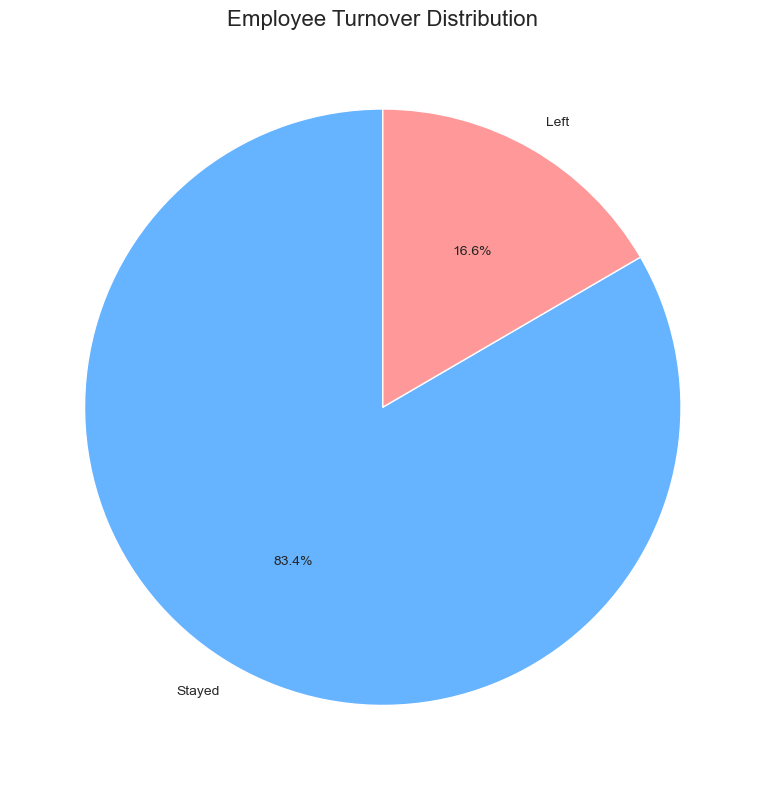

In [10]:
# Employee turnover distribution
plt.figure(figsize=(10, 8))
turnover_counts = hr_data_engineered['left_company'].value_counts()
turnover_percent = hr_data_engineered['left_company'].value_counts(normalize=True) * 100

# Print the percentages
print("Turnover distribution:")
print(f"Stayed: {turnover_percent[0]:.1f}%")
print(f"Left: {turnover_percent[1]:.1f}%")

# Create pie chart
plt.pie(turnover_counts, labels=['Stayed', 'Left'] if turnover_counts.index[0] == 0 else ['Left', 'Stayed'],
        autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'],
        wedgeprops={'edgecolor': 'w', 'linewidth': 1})

plt.title('Employee Turnover Distribution', fontsize=16)
plt.tight_layout()
plt.savefig('plots/turnover_distribution.png')
plt.show()

### 2.2.2 Satisfaction Level and Evaluation Score

Let's explore how satisfaction levels and evaluation scores relate to turnover.

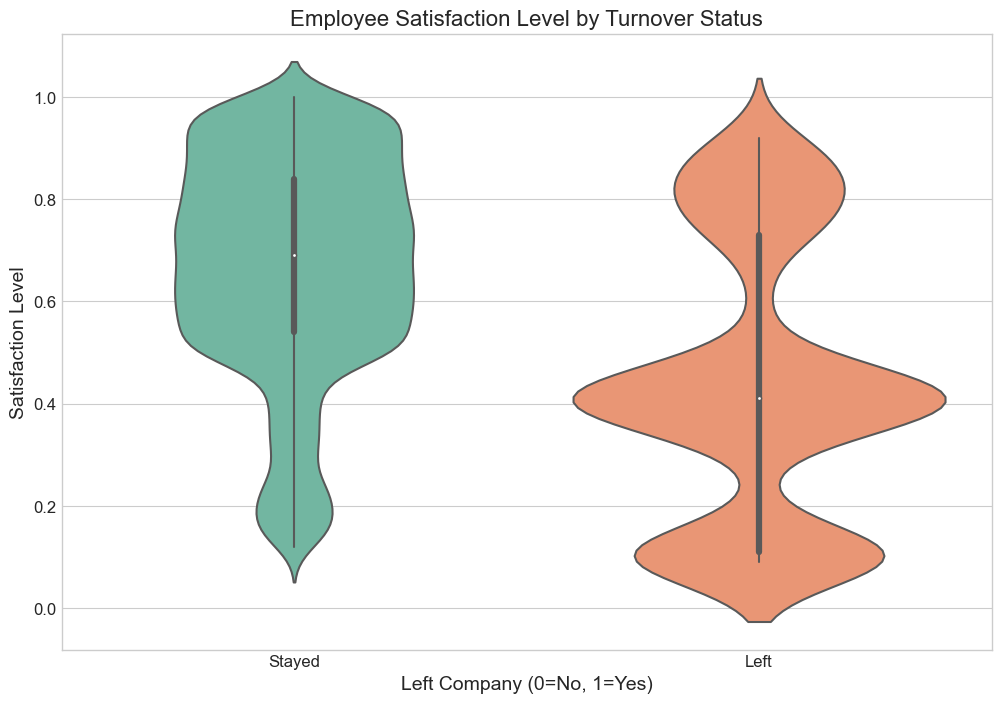

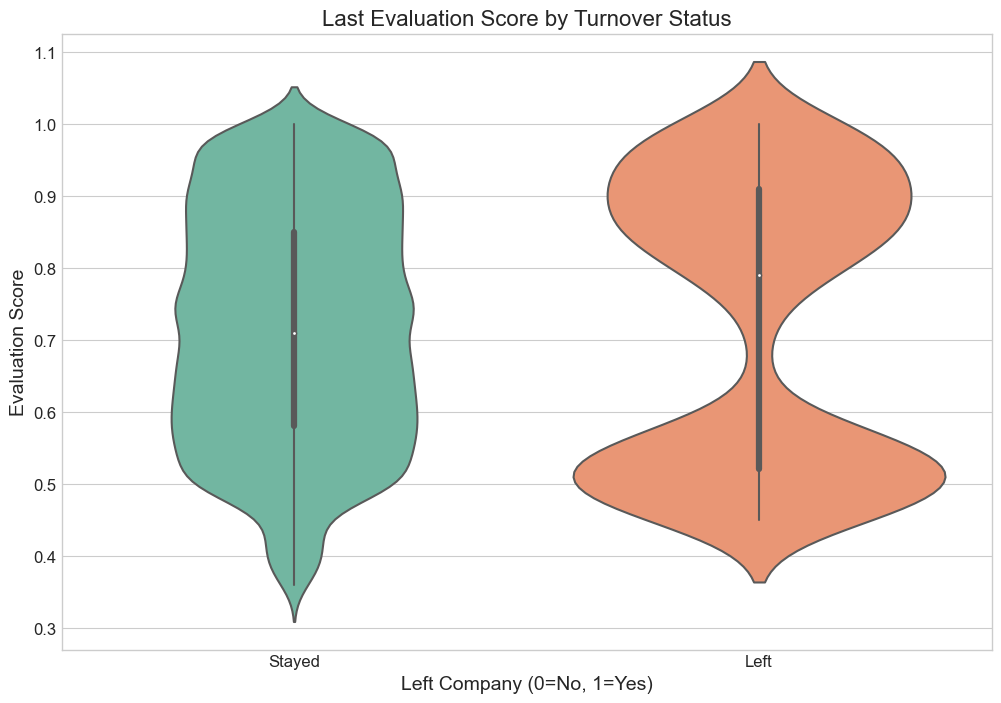

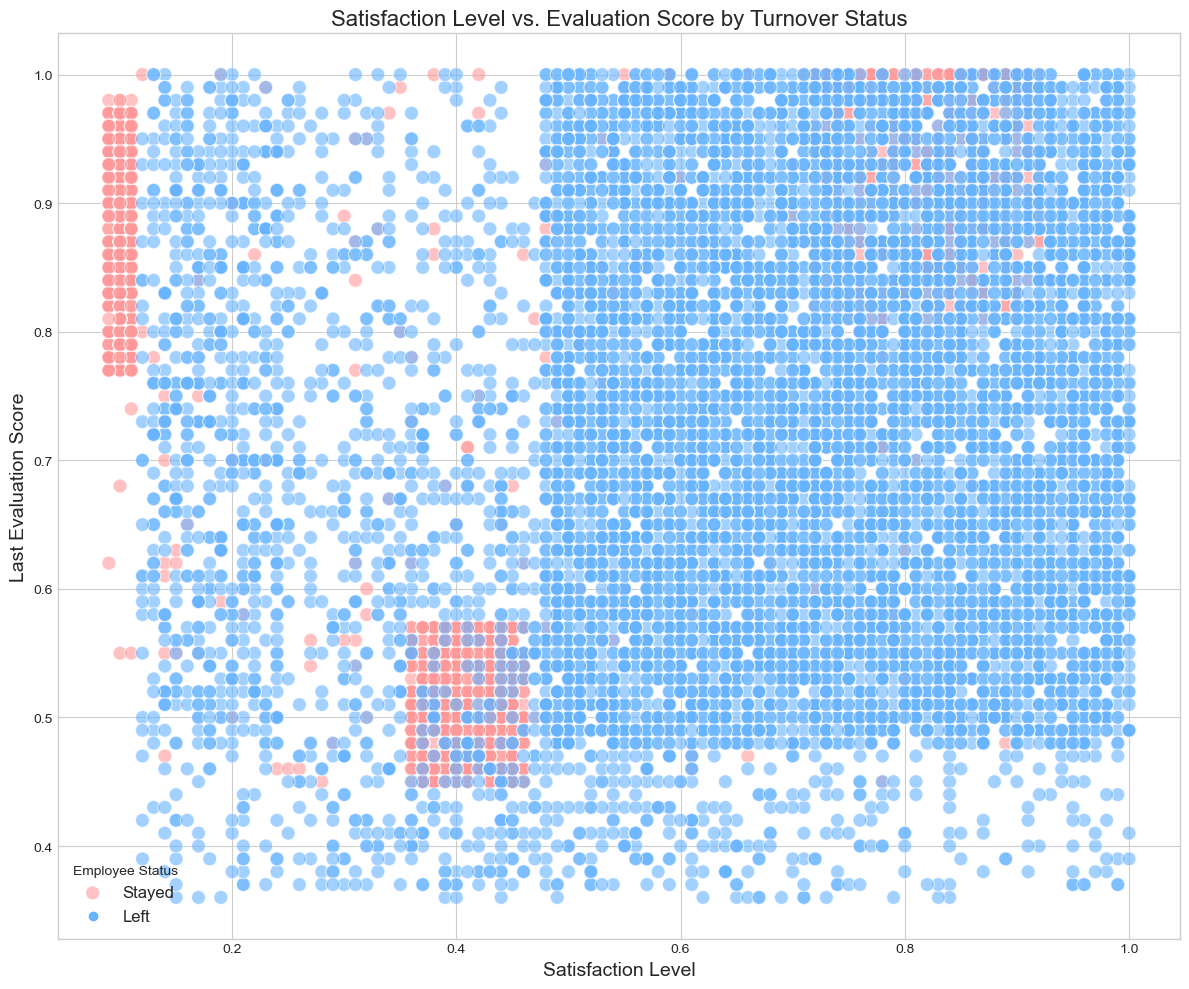

In [11]:
# 1. Satisfaction level by turnover status
plt.figure(figsize=(12, 8))
sns.violinplot(x='left_company', y='satisfaction_level', data=hr_data_engineered, inner='box', palette='Set2')
plt.title('Employee Satisfaction Level by Turnover Status', fontsize=16)
plt.xlabel('Left Company (0=No, 1=Yes)', fontsize=14)
plt.ylabel('Satisfaction Level', fontsize=14)
plt.xticks([0, 1], ['Stayed', 'Left'], fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('plots/satisfaction_by_turnover.png')
plt.show()

# 2. Last evaluation score by turnover status
plt.figure(figsize=(12, 8))
sns.violinplot(x='left_company', y='last_evaluation', data=hr_data_engineered, inner='box', palette='Set2')
plt.title('Last Evaluation Score by Turnover Status', fontsize=16)
plt.xlabel('Left Company (0=No, 1=Yes)', fontsize=14)
plt.ylabel('Evaluation Score', fontsize=14)
plt.xticks([0, 1], ['Stayed', 'Left'], fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('plots/evaluation_by_turnover.png')
plt.show()

# 3. Satisfaction vs. Evaluation
plt.figure(figsize=(12, 10))
scatter = sns.scatterplot(data=hr_data_engineered, x='satisfaction_level', y='last_evaluation', 
                hue='left_company', palette=['#66b3ff', '#ff9999'], 
                alpha=0.6, s=100)
plt.title('Satisfaction Level vs. Evaluation Score by Turnover Status', fontsize=16)
plt.xlabel('Satisfaction Level', fontsize=14)
plt.ylabel('Last Evaluation Score', fontsize=14)
plt.legend(title='Employee Status', labels=['Stayed', 'Left'], fontsize=12)
plt.tight_layout()
plt.savefig('plots/satisfaction_vs_evaluation.png')
plt.show()

### 2.2.3 Workload Analysis

Let's explore the relationship between workload (number of projects and monthly hours) and turnover.

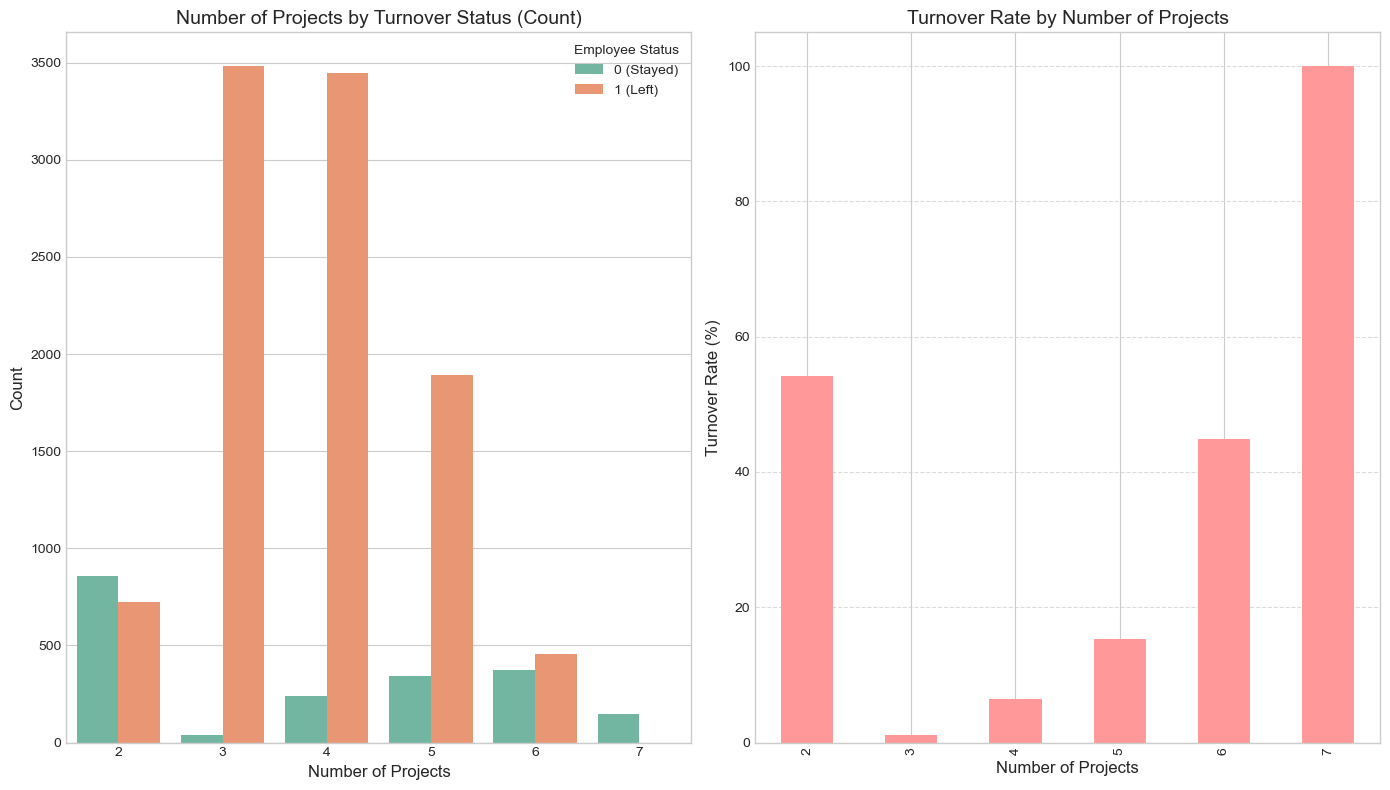

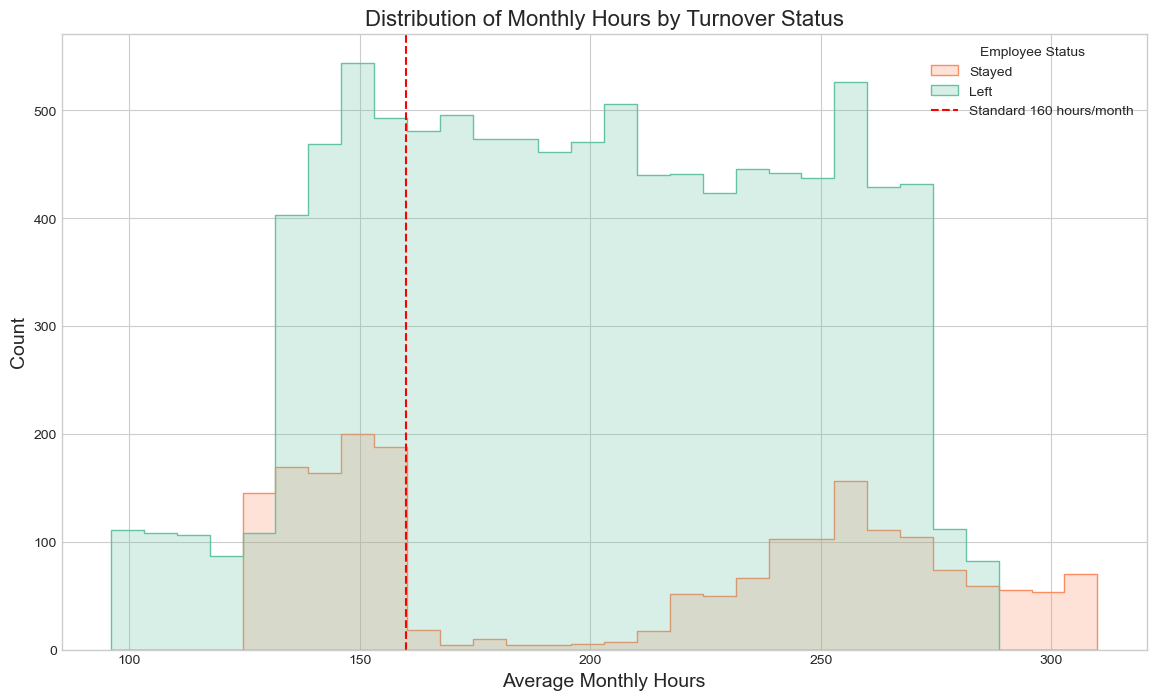

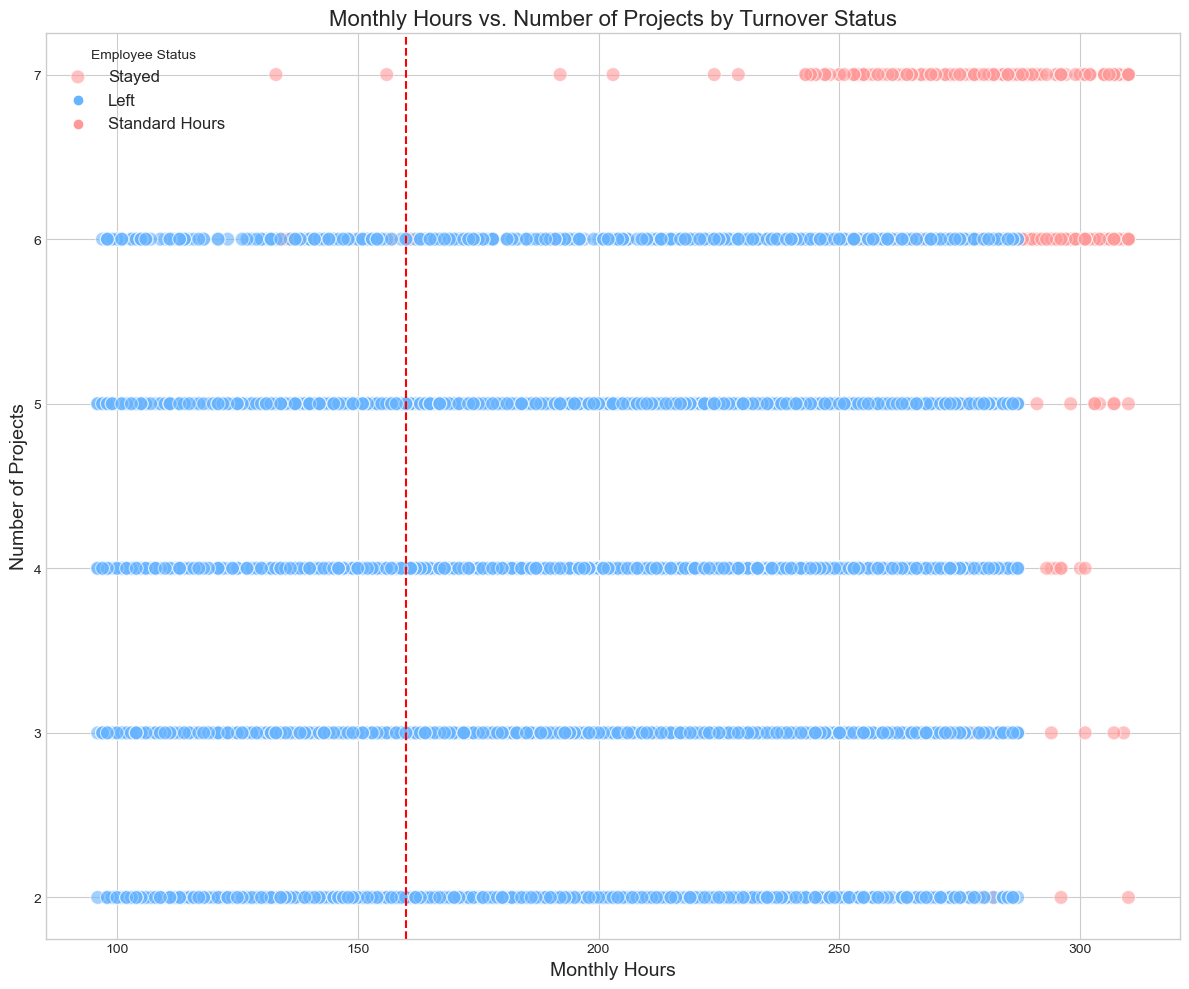

In [12]:
# 1. Number of projects by turnover status
plt.figure(figsize=(14, 8))
project_turnover = pd.crosstab(hr_data_engineered['num_projects'], hr_data_engineered['left_company'])
project_turnover_pct = project_turnover.div(project_turnover.sum(axis=1), axis=0) * 100

# Plot count
plt.subplot(1, 2, 1)
# Convert left_company to string type if needed
hr_data_engineered['left_company_str'] = hr_data_engineered['left_company'].astype(str)
sns.countplot(data=hr_data_engineered, x='num_projects', hue='left_company_str', palette='Set2')
plt.title('Number of Projects by Turnover Status (Count)', fontsize=14)
plt.xlabel('Number of Projects', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Employee Status', labels=['0 (Stayed)', '1 (Left)'])

# Plot percentage
plt.subplot(1, 2, 2)
project_turnover_pct[1].plot(kind='bar', color='#ff9999', figsize=(14, 8))
plt.title('Turnover Rate by Number of Projects', fontsize=14)
plt.xlabel('Number of Projects', fontsize=12)
plt.ylabel('Turnover Rate (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('plots/projects_by_turnover.png')
plt.show()

# 2. Monthly hours distribution by turnover status
plt.figure(figsize=(14, 8))
sns.histplot(data=hr_data_engineered, x='monthly_hours', hue='left_company', bins=30, element='step', 
             palette='Set2', common_norm=False)
plt.axvline(x=160, color='red', linestyle='--', label='Standard 160 hours/month')
plt.title('Distribution of Monthly Hours by Turnover Status', fontsize=16)
plt.xlabel('Average Monthly Hours', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Employee Status', labels=['Stayed', 'Left', 'Standard 160 hours/month'])
plt.savefig('plots/monthly_hours_distribution.png')
plt.show()

# 3. Monthly Hours vs Number of Projects
plt.figure(figsize=(12, 10))
scatter = sns.scatterplot(data=hr_data_engineered, x='monthly_hours', y='num_projects', 
                hue='left_company', palette=['#66b3ff', '#ff9999'], 
                alpha=0.6, s=100)
plt.axvline(x=160, color='red', linestyle='--', label='Standard 160 hours/month')
plt.title('Monthly Hours vs. Number of Projects by Turnover Status', fontsize=16)
plt.xlabel('Monthly Hours', fontsize=14)
plt.ylabel('Number of Projects', fontsize=14)
plt.legend(title='Employee Status', labels=['Stayed', 'Left', 'Standard Hours'], fontsize=12)
plt.tight_layout()
plt.savefig('plots/hours_vs_projects.png')
plt.show()

### 2.2.4 Tenure and Department Analysis

Let's examine how time spent at the company and department relate to turnover.

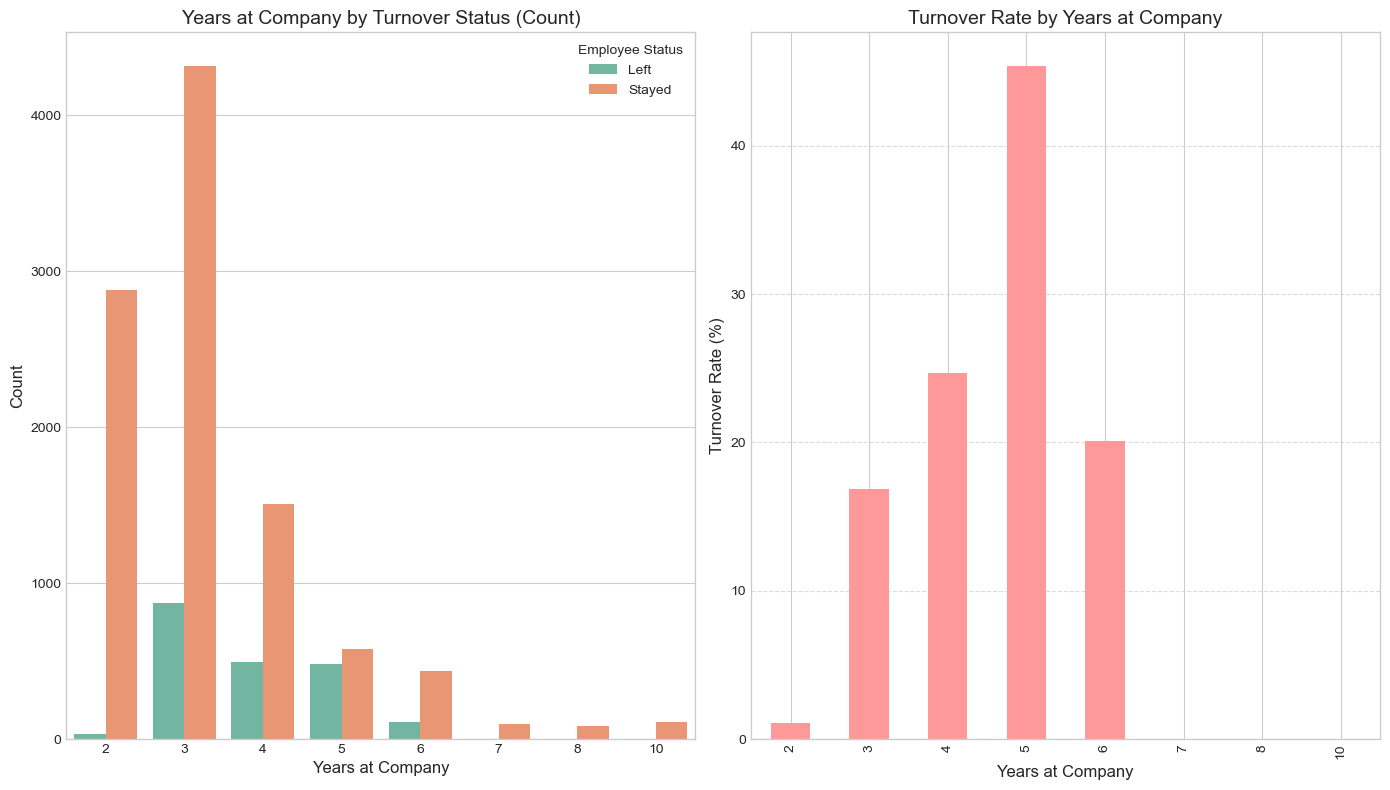

<Figure size 1400x800 with 0 Axes>

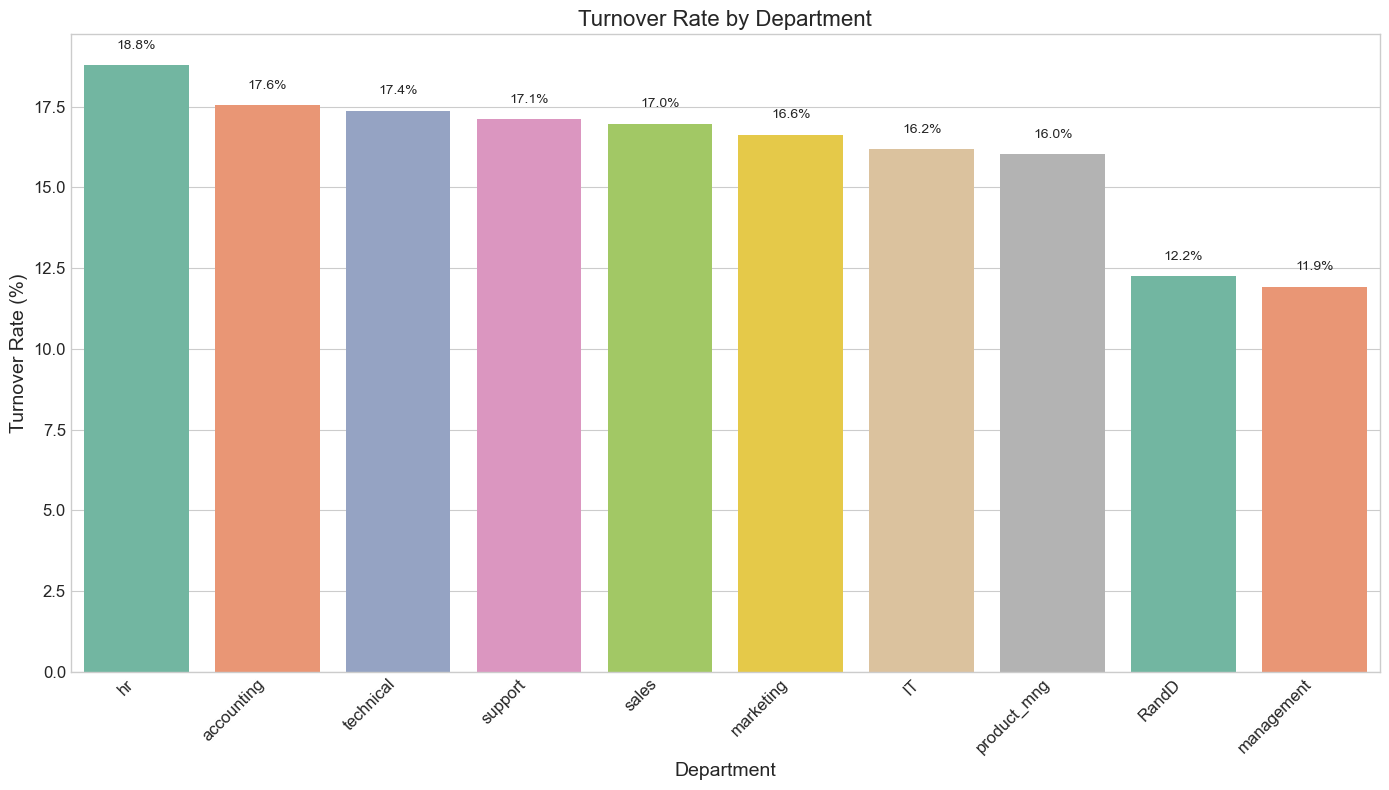

In [13]:
# 1. Tenure distribution by turnover status
plt.figure(figsize=(14, 8))
tenure_turnover = pd.crosstab(hr_data_engineered['tenure'], hr_data_engineered['left_company'])
tenure_turnover_pct = tenure_turnover.div(tenure_turnover.sum(axis=1), axis=0) * 100

# Create a mapped column for meaningful labels
hr_data_engineered['turnover_status'] = hr_data_engineered['left_company'].map({0: 'Stayed', 1: 'Left'})

# Plot count
plt.subplot(1, 2, 1)
sns.countplot(data=hr_data_engineered, x='tenure', hue='turnover_status', palette='Set2')
plt.title('Years at Company by Turnover Status (Count)', fontsize=14)
plt.xlabel('Years at Company', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Employee Status')

# Plot percentage
plt.subplot(1, 2, 2)
tenure_turnover_pct[1].plot(kind='bar', color='#ff9999')
plt.title('Turnover Rate by Years at Company', fontsize=14)
plt.xlabel('Years at Company', fontsize=12)
plt.ylabel('Turnover Rate (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('plots/tenure_by_turnover.png')
plt.show()
# 2. Turnover rate by department
plt.figure(figsize=(14, 8))
dept_turnover = pd.crosstab(hr_data_engineered['department'], hr_data_engineered['left_company'])
dept_turnover['total'] = dept_turnover.sum(axis=1)
dept_turnover['turnover_rate'] = (dept_turnover[1] / dept_turnover['total'] * 100).round(2)
dept_turnover = dept_turnover.sort_values('turnover_rate', ascending=False)

# Plot the turnover rate by department
turnover_rates = dept_turnover['turnover_rate']
plt.figure(figsize=(14, 8))
bar_plot = sns.barplot(x=turnover_rates.index, y=turnover_rates.values, palette='Set2')
plt.title('Turnover Rate by Department', fontsize=16)
plt.xlabel('Department', fontsize=14)
plt.ylabel('Turnover Rate (%)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Add value labels on bars
for i, v in enumerate(turnover_rates.values):
    bar_plot.text(i, v + 0.5, f"{v:.1f}%", ha='center', fontsize=10)
    
plt.tight_layout()
plt.savefig('plots/turnover_by_department.png')
plt.show()

### 2.2.5 Salary and Risk Factor Analysis

Finally, let's examine how salary and our engineered risk factors relate to turnover.

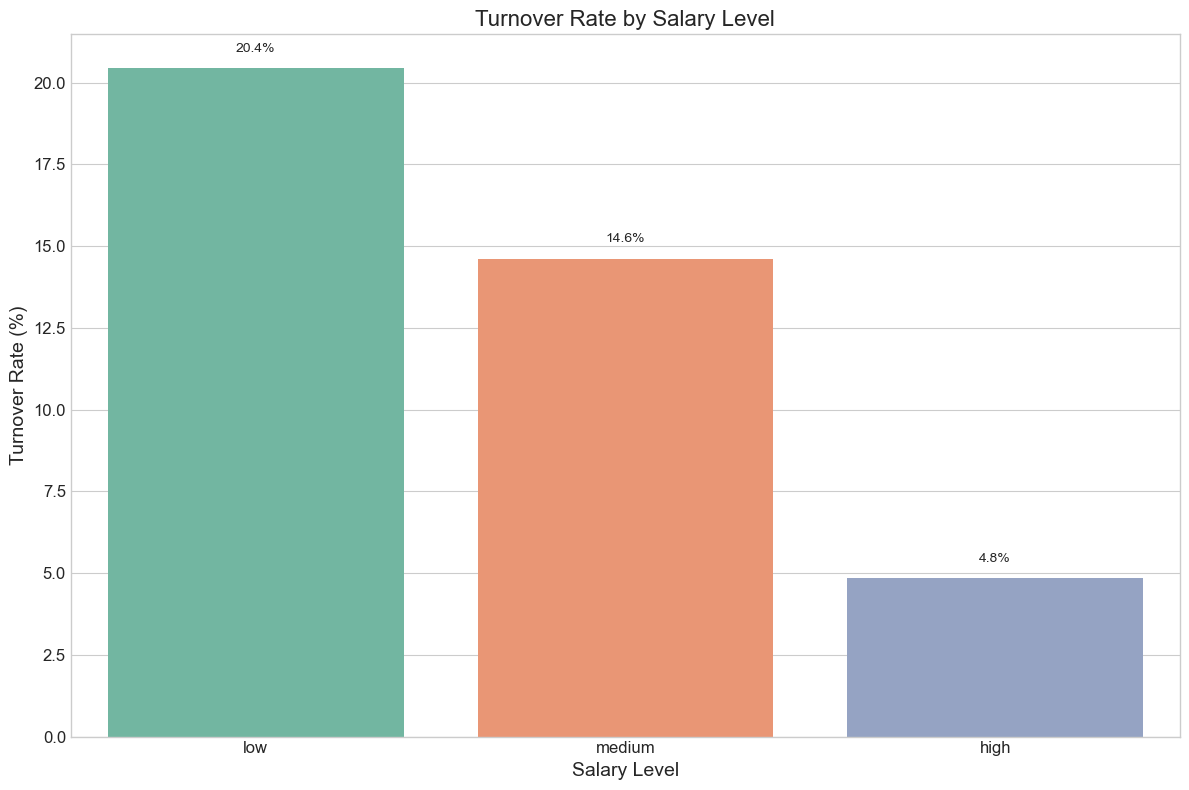

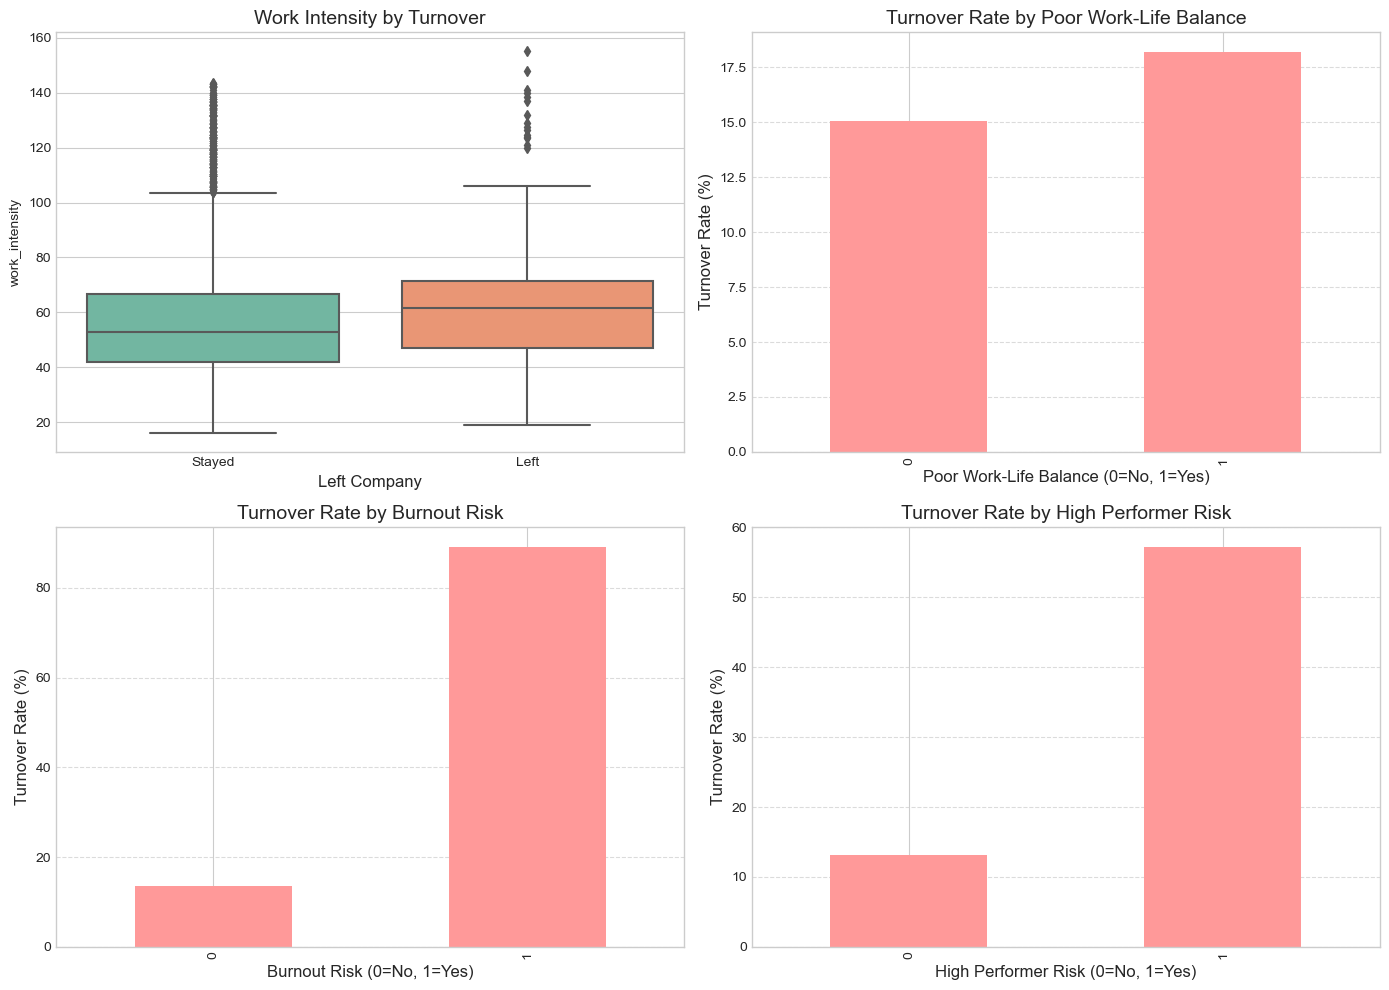

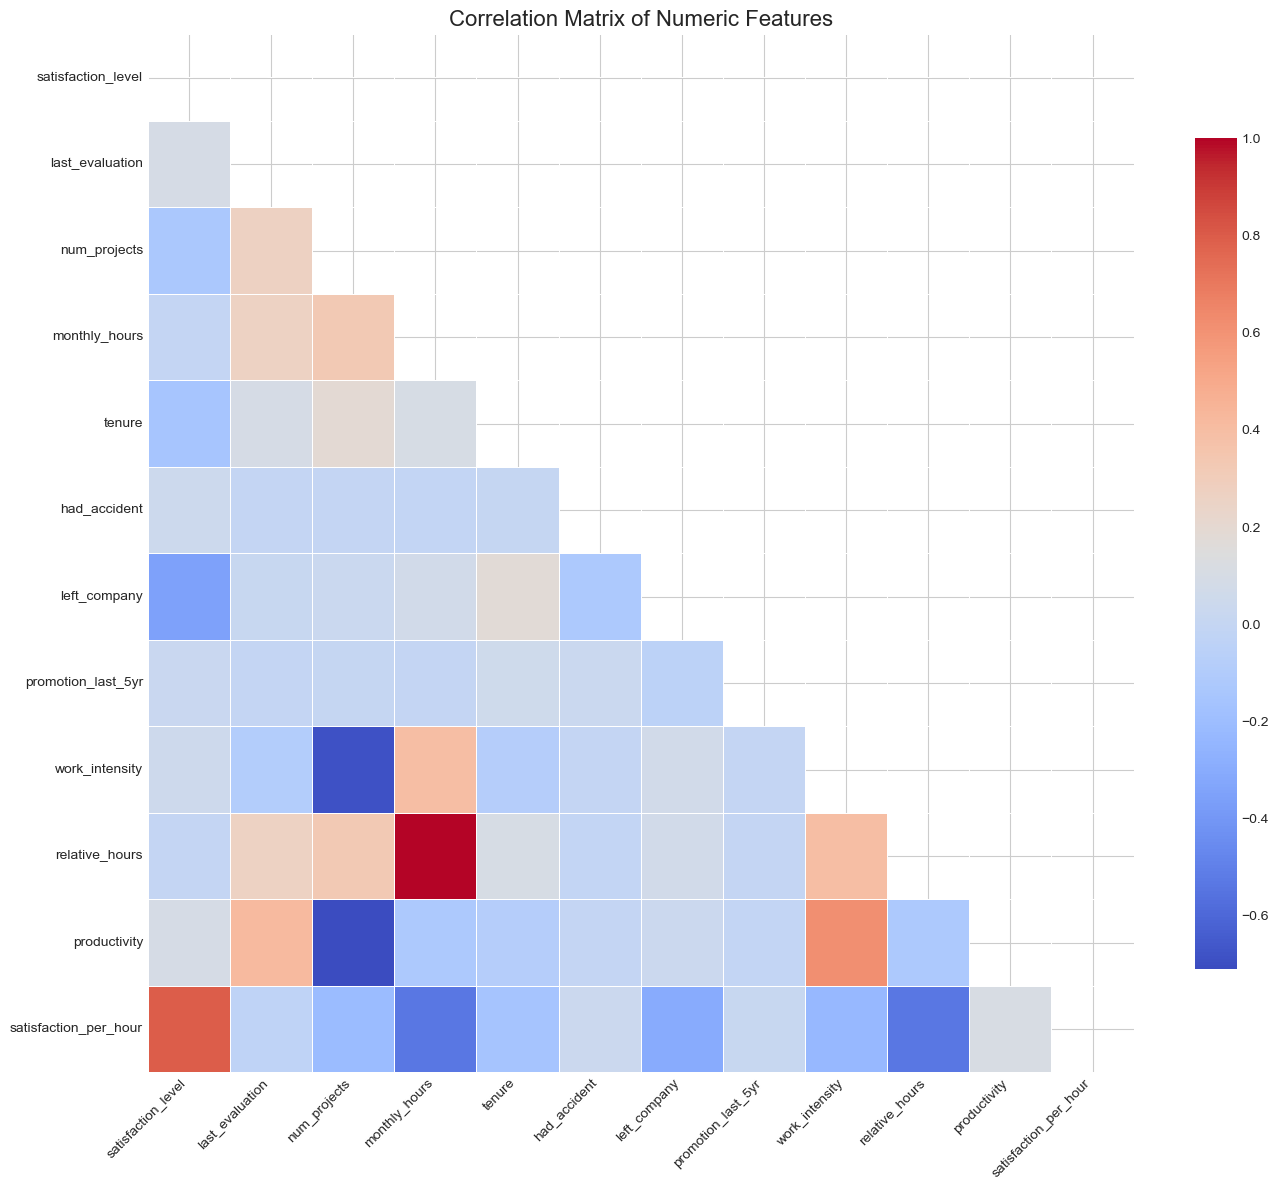

In [14]:
# 1. Turnover rate by salary level
plt.figure(figsize=(12, 8))
salary_turnover = pd.crosstab(hr_data_engineered['salary_level'], hr_data_engineered['left_company'])
salary_turnover['total'] = salary_turnover.sum(axis=1)
salary_turnover['turnover_rate'] = (salary_turnover[1] / salary_turnover['total'] * 100).round(2)

# Order by salary level (low, medium, high)
salary_order = ['low', 'medium', 'high']
salary_turnover = salary_turnover.reindex(salary_order)

# Plot the turnover rate by salary level
turnover_rates = salary_turnover['turnover_rate']
bar_plot = sns.barplot(x=turnover_rates.index, y=turnover_rates.values, palette='Set2')
plt.title('Turnover Rate by Salary Level', fontsize=16)
plt.xlabel('Salary Level', fontsize=14)
plt.ylabel('Turnover Rate (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add value labels on bars
for i, v in enumerate(turnover_rates.values):
    bar_plot.text(i, v + 0.5, f"{v:.1f}%", ha='center', fontsize=10)
    
plt.tight_layout()
plt.savefig('plots/turnover_by_salary.png')
plt.show()

# 2. Risk Factors Analysis
plt.figure(figsize=(14, 10))

# Work intensity by turnover
plt.subplot(2, 2, 1)
sns.boxplot(x='left_company', y='work_intensity', data=hr_data_engineered, palette='Set2')
plt.title('Work Intensity by Turnover', fontsize=14)
plt.xlabel('Left Company', fontsize=12)
plt.xticks([0, 1], ['Stayed', 'Left'], fontsize=10)

# Work-life balance by turnover
plt.subplot(2, 2, 2)
balance_count = pd.crosstab(hr_data_engineered['poor_work_life_balance'], hr_data_engineered['left_company'])
balance_pct = balance_count.div(balance_count.sum(axis=1), axis=0) * 100
balance_pct[1].plot(kind='bar', color='#ff9999')
plt.title('Turnover Rate by Poor Work-Life Balance', fontsize=14)
plt.xlabel('Poor Work-Life Balance (0=No, 1=Yes)', fontsize=12)
plt.ylabel('Turnover Rate (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Burnout risk by turnover
plt.subplot(2, 2, 3)
burnout_count = pd.crosstab(hr_data_engineered['burnout_risk'], hr_data_engineered['left_company'])
burnout_pct = burnout_count.div(burnout_count.sum(axis=1), axis=0) * 100
burnout_pct[1].plot(kind='bar', color='#ff9999')
plt.title('Turnover Rate by Burnout Risk', fontsize=14)
plt.xlabel('Burnout Risk (0=No, 1=Yes)', fontsize=12)
plt.ylabel('Turnover Rate (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# High performer risk by turnover
plt.subplot(2, 2, 4)
performer_count = pd.crosstab(hr_data_engineered['high_performer_risk'], hr_data_engineered['left_company'])
performer_pct = performer_count.div(performer_count.sum(axis=1), axis=0) * 100
performer_pct[1].plot(kind='bar', color='#ff9999')
plt.title('Turnover Rate by High Performer Risk', fontsize=14)
plt.xlabel('High Performer Risk (0=No, 1=Yes)', fontsize=12)
plt.ylabel('Turnover Rate (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('plots/engineered_features.png')
plt.show()

# 3. Correlation matrix
plt.figure(figsize=(14, 12))
numeric_cols = hr_data_engineered.select_dtypes(include=['float64', 'int64']).columns
correlation = hr_data_engineered[numeric_cols].corr()

# Create a mask for the upper triangle
mask = np.triu(correlation)

heatmap = sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', 
                      mask=mask, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Numeric Features', fontsize=16)
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig('plots/correlation_heatmap.png')
plt.show()

# Part 3: Model Building and Evaluation


## 3.1 Data Preparation for Modeling

#### Now that we've explored and engineered our data, let's prepare it for modeling by:
 - Splitting features and target variable
 - Creating a preprocessing pipeline for numerical and categorical features
 - Splitting the data into training, validation, and test sets

In [15]:
# Set up logging configuration
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("data_preparation.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

def prepare_data_for_modeling(
    df, 
    target_column='left_company', 
    categorical_features=None, 
    numerical_features=None,
    test_size=0.2,
    val_size=0.25,
    random_state=42,
    apply_smote=True,
    smote_sampling_strategy='auto',
    feature_selection=None,
    n_features_to_select=None,
    use_cross_validation=False,
    cv_folds=5,
    save_pipeline=True,
    pipeline_path='model/preprocessor.pkl',
    verbose=True
):
    """
    Comprehensive data preparation for machine learning modeling with optional SMOTE,
    feature selection, and cross-validation support.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe containing all features and target variable
    target_column : str, optional (default='left_company')
        Name of the target column to predict
    categorical_features : list, optional
        List of categorical feature column names
    numerical_features : list, optional
        List of numerical feature column names
    test_size : float, optional (default=0.2)
        Proportion of the dataset to include in the test split
    val_size : float, optional (default=0.25)
        Proportion of the training set to include in the validation split
    random_state : int, optional (default=42)
        Controls the shuffling applied to the data before splitting
    apply_smote : bool, optional (default=False)
        Whether to apply SMOTE to training data
    smote_sampling_strategy : str or float, optional (default='auto')
        SMOTE sampling strategy
    feature_selection : str, optional (default=None)
        Feature selection method: 'selectkbest', 'selectfrommodel', or None
    n_features_to_select : int, optional (default=None)
        Number of features to select when using feature selection
    use_cross_validation : bool, optional (default=False)
        Whether to use cross-validation instead of a validation split
    cv_folds : int, optional (default=5)
        Number of folds for cross-validation
    save_pipeline : bool, optional (default=False)
        Whether to save the preprocessing pipeline to disk
    pipeline_path : str, optional (default='model/preprocessor.pkl')
        Path to save the preprocessing pipeline
    verbose : bool, optional (default=True)
        Whether to print information about the preprocessing steps
    
    Returns:
    --------
    dict
        Prepared datasets with additional metadata
    """
    # Default feature lists if not provided
    if categorical_features is None:
        categorical_features = [
            'department', 
            'salary_level'
        ]
    
    if numerical_features is None:
        numerical_features = [
            'satisfaction_level', 
            'last_evaluation', 
            'num_projects', 
            'monthly_hours', 
            'tenure'
        ]
    
    # Step 1: Data quality checks
    if verbose:
        logger.info("Running data quality checks...")
    
    # Check for missing values
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:
        logger.warning(f"Missing values detected:\n{missing_values[missing_values > 0]}")
    
    # Check for outliers in numerical features
    for col in numerical_features:
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            outliers = df[(df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)]
            if len(outliers) > 0:
                logger.warning(f"Outliers detected in {col}: {len(outliers)} values")
    
    # Remove redundant columns
    def remove_redundant_columns(dataframe, target_col):
        """Remove columns related to the target variable"""
        columns_to_drop = [
            col for col in dataframe.columns 
            if (col.startswith(target_col) or 
                col.lower() in ['turnover_status', 'left_status', 'employee_status'])
            and col != target_col
        ]
        return dataframe.drop(columns=columns_to_drop, errors='ignore')
    
    # Clean the dataframe
    df_cleaned = remove_redundant_columns(df.copy(), target_column)
    
    # Separate features and target
    X = df_cleaned.drop(columns=[target_column])
    y = df_cleaned[target_column]
    
    # Step 2: Split the data into train and test sets (and validation if not using CV)
    if verbose:
        logger.info("Splitting data into train/test sets...")
    
    # Always create a test set
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Either create a validation set or prepare for cross-validation
    if not use_cross_validation:
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_size, random_state=random_state, stratify=y_temp
        )
    else:
        X_train, y_train = X_temp, y_temp
        X_val, y_val = None, None
        if verbose:
            logger.info(f"Using {cv_folds}-fold cross-validation instead of validation split")
    
    # Step 3: Create preprocessing pipelines
    if verbose:
        logger.info("Creating preprocessing pipeline...")
    
    # Initialize the preprocessing steps
    preprocessing_steps = [
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse=False), categorical_features)
    ]
    
    # Create the column transformer
    preprocessor = ColumnTransformer(
        transformers=preprocessing_steps,
        remainder='passthrough'
    )
    
    # Initialize feature selection if requested
    if feature_selection:
        if verbose:
            logger.info(f"Setting up feature selection using {feature_selection}...")
        
        if feature_selection == 'selectkbest':
            feature_selector = SelectKBest(f_classif, k=n_features_to_select or 'all')
        elif feature_selection == 'selectfrommodel':
            feature_selector = SelectFromModel(
                RandomForestClassifier(random_state=random_state),
                max_features=n_features_to_select
            )
        else:
            logger.warning(f"Unknown feature selection method: {feature_selection}. Using all features.")
            feature_selector = None
        
        # Create a pipeline with preprocessing and optional feature selection
        if feature_selector:
            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('feature_selection', feature_selector)
            ])
        else:
            pipeline = Pipeline([('preprocessor', preprocessor)])
    else:
        pipeline = Pipeline([('preprocessor', preprocessor)])
    
    # Step 4: Apply preprocessing (and feature selection if enabled)
    if verbose:
        logger.info("Applying preprocessing to data...")
    
    # Fit and transform the training data
    X_train_processed = pipeline.fit_transform(X_train, y_train)
    
    # Transform validation and test sets
    if not use_cross_validation:
        X_val_processed = pipeline.transform(X_val)
    else:
        X_val_processed = None
        
    X_test_processed = pipeline.transform(X_test)
    
    # Step 5: Apply SMOTE (only to training data and only if not using CV)
    if apply_smote and not use_cross_validation:
        try:
            from imblearn.over_sampling import SMOTE
            
            if verbose:
                logger.info(f"Applying SMOTE with sampling strategy: {smote_sampling_strategy}")
            
            # Store original class distribution for reporting
            original_train_len = len(y_train)
            original_distribution = pd.Series(y_train).value_counts(normalize=True)
            
            # Apply SMOTE
            smote = SMOTE(
                sampling_strategy=smote_sampling_strategy, 
                random_state=random_state
            )
            
            X_train_processed, y_train = smote.fit_resample(
                X_train_processed, y_train
            )
            
            # Report results if verbose
            if verbose:
                logger.info("\n--- SMOTE Oversampling Summary ---")
                logger.info(f"Original training set shape: {original_train_len}")
                logger.info(f"Original training class distribution:\n{original_distribution}")
                logger.info(f"Resampled training set shape: {len(y_train)}")
                logger.info(f"Resampled class distribution:\n{pd.Series(y_train).value_counts(normalize=True)}")
        
        except ImportError:
            logger.warning("SMOTE could not be applied. Please install imbalanced-learn (pip install imbalanced-learn)")
    
    # Step 6: Set up cross-validation if requested
    cv_splits = None
    if use_cross_validation:
        cv_splits = list(StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state).split(X_train, y_train))
        if verbose:
            logger.info(f"Created {len(cv_splits)} cross-validation splits")
    
    # Step 7: Get feature names after preprocessing
    try:
        onehot_encoder = preprocessor.named_transformers_['cat']
        cat_feature_names = onehot_encoder.get_feature_names_out(categorical_features).tolist()
        
        # Get all feature names, including those that weren't transformed
        processed_feature_names = (
            numerical_features + 
            cat_feature_names + 
            [col for col in X_train.columns if col not in numerical_features + categorical_features]
        )
        
        # Adjust feature names if feature selection was applied
        if feature_selection and feature_selector and hasattr(feature_selector, 'get_support'):
            feature_mask = pipeline.named_steps['feature_selection'].get_support()
            processed_feature_names = [name for selected, name in zip(feature_mask, processed_feature_names) if selected]
            if verbose:
                logger.info(f"Selected {len(processed_feature_names)} features after feature selection")
    except Exception as e:
        logger.warning(f"Error getting feature names: {str(e)}")
        processed_feature_names = [f"feature_{i}" for i in range(X_train_processed.shape[1])]
    
    # Step 8: Save pipeline if requested
    if save_pipeline:
        try:
            # Create directory if it doesn't exist
            os.makedirs(os.path.dirname(pipeline_path), exist_ok=True)
            
            # Save the pipeline
            joblib.dump(pipeline, pipeline_path)
            if verbose:
                logger.info(f"Preprocessing pipeline saved to {pipeline_path}")
        except Exception as e:
            logger.error(f"Error saving pipeline: {str(e)}")
    
    # Step 9: Print dataset information if verbose
    if verbose:
        logger.info("\n--- Data Preparation Summary ---")
        logger.info(f"Total samples: {len(df)}")
        logger.info(f"Training set:   {X_train_processed.shape} | Positive class: {y_train.mean():.2%}")
        
        if not use_cross_validation:
            logger.info(f"Validation set: {X_val_processed.shape}   | Positive class: {y_val.mean():.2%}")
        else:
            logger.info(f"Using {cv_folds}-fold cross-validation instead of validation split")
            
        logger.info(f"Testing set:    {X_test_processed.shape}  | Positive class: {y_test.mean():.2%}")
        logger.info(f"Total features after preprocessing: {len(processed_feature_names)}")
    
    # Step 10: Return comprehensive dictionary with processed data
    result = {
        # Original datasets
        'X_train_original': X_train,
        'X_test_original': X_test,
        
        # Processed datasets
        'X_train_processed': X_train_processed,
        'X_test_processed': X_test_processed,
        
        # Target variables
        'y_train': y_train,
        'y_test': y_test,
        
        # Metadata
        'pipeline': pipeline,
        'feature_names': processed_feature_names,
        'categorical_features': categorical_features,
        'numerical_features': numerical_features
    }
    
    # Add validation data if not using cross-validation
    if not use_cross_validation:
        result.update({
            'X_val_original': X_val,
            'X_val_processed': X_val_processed,
            'y_val': y_val
        })
    # Add cross-validation data if using CV
    else:
        result.update({
            'cv_splits': cv_splits,
            'cv_folds': cv_folds
        })
    
    return result

# Application example for HR analytics data
if __name__ == "__main__":
    # Call the enhanced function with appropriate parameters for HR turnover analysis
    model_data = prepare_data_for_modeling(
        df=hr_data_engineered,  # Your engineered dataset
        target_column='left_company',
        
        # Specify relevant features based on EDA
        categorical_features=['department', 'salary_level'],
        numerical_features=[
            'satisfaction_level', 
            'last_evaluation', 
            'num_projects', 
            'monthly_hours', 
            'tenure', 
            'work_intensity',
            'poor_work_life_balance',
            'burnout_risk',
            'high_performer_risk',
            'satisfaction_per_hour',
            'relative_hours'
        ],
        
        # Split parameters
        test_size=0.2,
        val_size=0.25,
        random_state=42,
        
        # Enable SMOTE to handle class imbalance
        # (since left_company=1 class is only about 16.6% of the data)
        apply_smote=True,
        smote_sampling_strategy='auto',  # or try 0.8 for slightly less aggressive balancing
        
        # Enable feature selection
        feature_selection='selectfrommodel',  # or 'selectkbest'
        n_features_to_select=10,  # Select top 10 most important features
        
        # Save the pipeline for later use in deployment
        save_pipeline=True,
        pipeline_path='model/hr_preprocessor.pkl',
        
        # Enable verbose output
        verbose=True
    )

    # Access the processed data for modeling
    X_train = model_data['X_train_processed']
    y_train = model_data['y_train']
    X_val = model_data['X_val_processed']
    y_val = model_data['y_val']
    X_test = model_data['X_test_processed']
    y_test = model_data['y_test']

    # Access the feature names
    feature_names = model_data['feature_names']

    # Access the preprocessing pipeline for later use
    pipeline = model_data['pipeline']

    # Print the selected features
    print("Selected features for modeling:")
    for i, feature in enumerate(feature_names):
        print(f"{i+1}. {feature}")

2025-03-29 15:06:57,829 - __main__ - INFO: Running data quality checks...
2025-03-29 15:06:57,840 - __main__ - WARNING: Outliers detected in tenure: 824 values
2025-03-29 15:06:57,840 - __main__ - WARNING: Outliers detected in work_intensity: 262 values
2025-03-29 15:06:57,847 - __main__ - WARNING: Outliers detected in burnout_risk: 476 values
2025-03-29 15:06:57,849 - __main__ - WARNING: Outliers detected in high_performer_risk: 953 values
2025-03-29 15:06:57,849 - __main__ - WARNING: Outliers detected in satisfaction_per_hour: 277 values
2025-03-29 15:06:57,857 - __main__ - INFO: Splitting data into train/test sets...
2025-03-29 15:06:57,861 - __main__ - INFO: Creating preprocessing pipeline...
2025-03-29 15:06:57,861 - __main__ - INFO: Setting up feature selection using selectfrommodel...
2025-03-29 15:06:57,861 - __main__ - INFO: Applying preprocessing to data...
2025-03-29 15:06:58,487 - __main__ - INFO: Applying SMOTE with sampling strategy: auto
2025-03-29 15:06:58,496 - __main_

Selected features for modeling:
1. satisfaction_level
2. last_evaluation
3. num_projects
4. monthly_hours
5. tenure
6. work_intensity
7. high_performer_risk
8. satisfaction_per_hour
9. relative_hours
10. productivity


## 3.2 Model Evaluation Function

In [16]:
def evaluate_model(model, data, model_name, use_scaled=False):
    """
    Train and evaluate a model on validation data.
    
    Parameters:
    -----------
    model : sklearn model
        The model to train and evaluate
    data : dict
        Dictionary containing data splits and other metadata
    model_name : str
        Name of the model for reporting
    use_scaled : bool, default=False
        Whether to use scaled features
        
    Returns:
    --------
    model : fitted model
        The trained model
    y_val_pred : array
        Predictions on validation data
    y_val_proba : array
        Predicted probabilities on validation data
    metrics : dict
        Dictionary of evaluation metrics
    """
    # Check which keys are available in the data dictionary
    if 'X_train_processed' in data:
        # Using the advanced preprocessing function
        X_train = data['X_train_processed']
        X_val = data['X_val_processed']
    elif 'X_train_scaled' in data and use_scaled:
        # Using the simpler function with scaling
        X_train = data['X_train_scaled']
        X_val = data['X_val_scaled']
    else:
        # Using the simpler function without scaling
        X_train = data['X_train']
        X_val = data['X_val']
    
    y_train = data['y_train']
    y_val = data['y_val']
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on validation set
    y_val_pred = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1]  # Probability of positive class
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)
    roc_auc = roc_auc_score(y_val, y_val_proba)
    
    # Confusion matrix
    cm = confusion_matrix(y_val, y_val_pred)
    
    # Print evaluation results
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    
    # Confusion matrix display
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Stayed', 'Left'])
    disp.plot(cmap='Blues', values_format='d', colorbar=False)
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'plots/confusion_matrix_{model_name.replace(" ", "_").lower()}.png')
    plt.show()
    
    # Return results
    metrics = {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }
    
    return model, y_val_pred, y_val_proba, metrics

## 3.3 Base Model Training and Evaluation


Evaluating Logistic Regression...
Model: Logistic Regression
Accuracy: 0.8545
Precision: 0.5342
Recall: 0.9623
F1 Score: 0.6870
ROC AUC: 0.9212

Confusion Matrix:
[[1666  334]
 [  15  383]]


<Figure size 800x600 with 0 Axes>

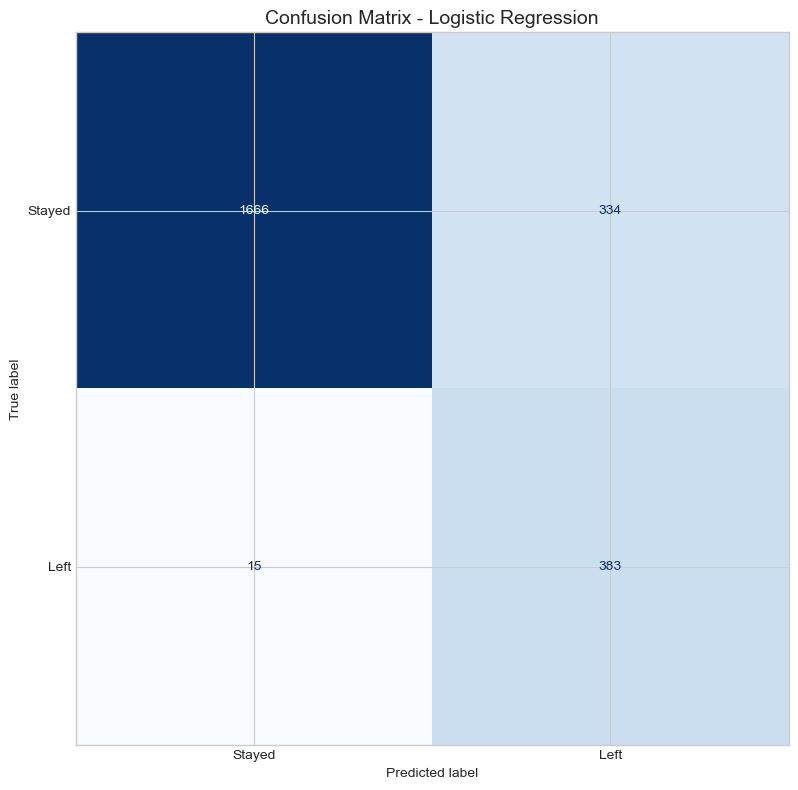


Evaluating Random Forest...
Model: Random Forest
Accuracy: 0.9837
Precision: 0.9687
Recall: 0.9322
F1 Score: 0.9501
ROC AUC: 0.9880

Confusion Matrix:
[[1988   12]
 [  27  371]]


<Figure size 800x600 with 0 Axes>

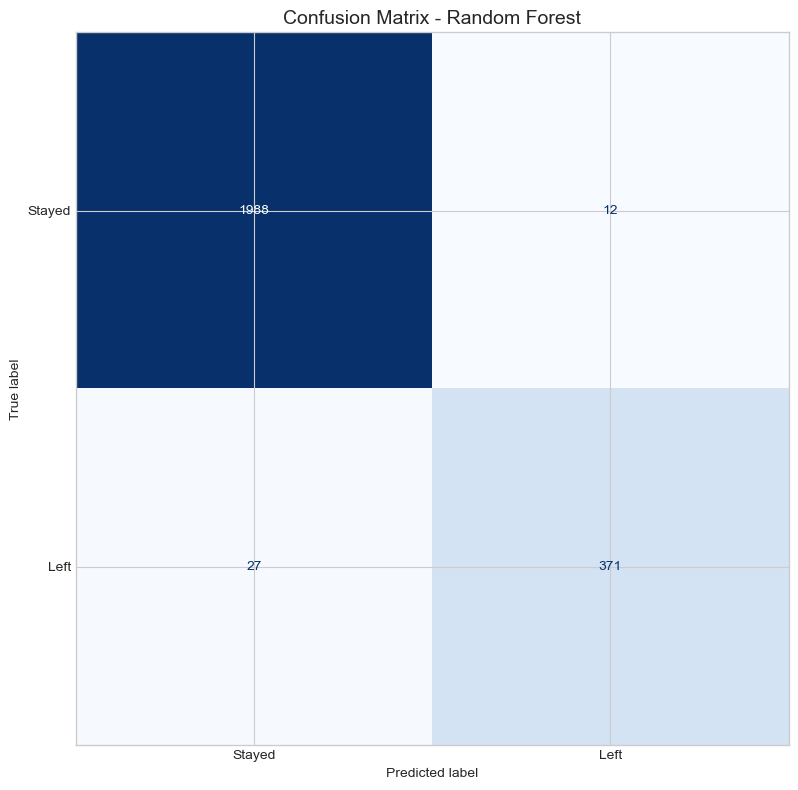


Evaluating XGBoost...
Model: XGBoost
Accuracy: 0.9625
Precision: 0.8468
Recall: 0.9447
F1 Score: 0.8931
ROC AUC: 0.9874

Confusion Matrix:
[[1932   68]
 [  22  376]]


<Figure size 800x600 with 0 Axes>

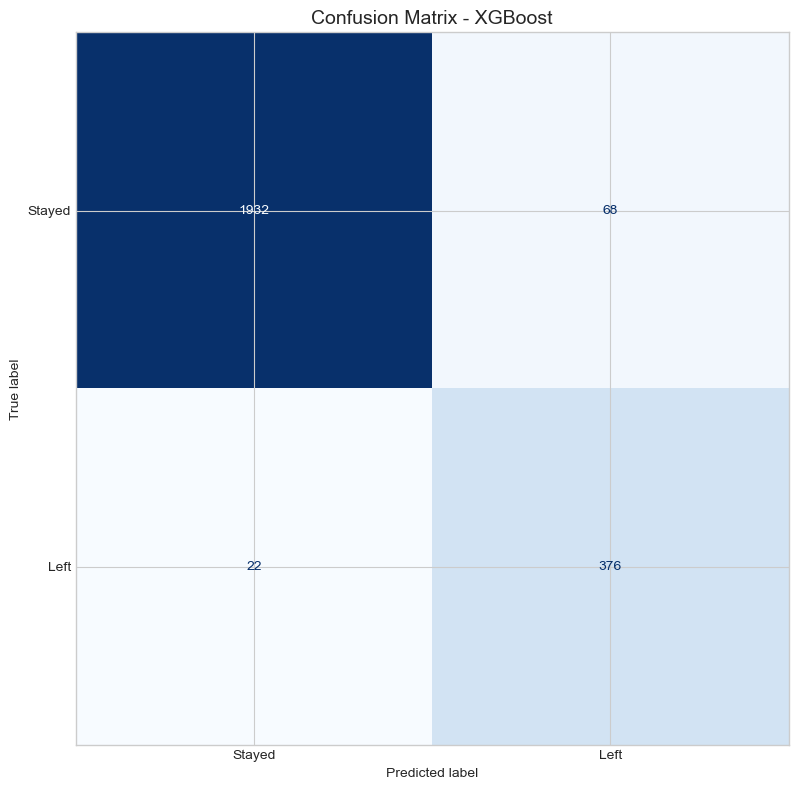


Model Comparison (Validation Set):
                     accuracy  precision    recall        f1   roc_auc
model_name                                                            
Random Forest        0.983736   0.968668  0.932161  0.950064  0.987997
XGBoost              0.962469   0.846847  0.944724  0.893112  0.987438
Logistic Regression  0.854462   0.534170  0.962312  0.686996  0.921227


In [17]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
)

## 3.3 Base Model Training and Evaluation

# Define models to evaluate
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, C=1.0, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=42, n_estimators=100, learning_rate=0.1, scale_pos_weight=5)
}

# Evaluate each model
results = []
for name, model in models.items():
    print(f"\nEvaluating {name}...")
    fitted_model, val_preds, val_proba, metrics = evaluate_model(model, model_data, name)
    results.append(metrics)

# Create comparison dataframe
comparison_df = pd.DataFrame(results)
print("\nModel Comparison (Validation Set):")
print(comparison_df.set_index('model_name').sort_values('f1', ascending=False))

## 3.4 Hyperparameter Tuning

In [18]:
# Determine best model from initial evaluation
best_initial_model = comparison_df.loc[comparison_df['f1'].idxmax(), 'model_name']
print(f"\nBest initial model based on F1 score: {best_initial_model}")

# Define hyperparameter grid for the best model
if best_initial_model == 'XGBoost':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'min_child_weight': [1, 3]
    }
    use_scaled = False
    model_class = XGBClassifier
elif best_initial_model == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    }
    use_scaled = False
    model_class = RandomForestClassifier
else:  # Logistic Regression
    param_grid = {
        'C': [0.01, 0.1, 1.0, 10.0],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'class_weight': [None, 'balanced']
    }
    use_scaled = True
    model_class = LogisticRegression

# First use RandomizedSearchCV to narrow down parameters
print(f"\nPerforming RandomizedSearchCV for {best_initial_model}...")
random_search = RandomizedSearchCV(
    estimator=model_class(random_state=42),
    param_distributions=param_grid,
    n_iter=20,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Train on appropriate dataset based on model type
X_train = model_data['X_train_processed']  
random_search.fit(X_train, model_data['y_train'])
print(f"Best parameters from random search: {random_search.best_params_}")
print(f"Best F1 score from random search: {random_search.best_score_:.4f}")

# Fine-tune with GridSearchCV around best parameters
best_params = random_search.best_params_

# Create refined parameter grid based on initial results
fine_tuned_params = {}
for param, value in best_params.items():
    if param == 'n_estimators':
        fine_tuned_params[param] = [max(value-50, 50), value, value+50]
    elif param == 'max_depth' and value is not None:
        fine_tuned_params[param] = [max(value-1, 1), value, value+1]
    elif param == 'learning_rate' and value > 0.01:
        fine_tuned_params[param] = [value/2, value, min(value*1.5, 1.0)]
    elif param in ['C'] and value > 0.01:
        fine_tuned_params[param] = [value/2, value, value*2]
    else:
        fine_tuned_params[param] = [value]

grid_search = GridSearchCV(
    estimator=model_class(random_state=42),
    param_grid=fine_tuned_params,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, model_data['y_train'])
print(f"Best parameters from grid search: {grid_search.best_params_}")
print(f"Best F1 score from grid search: {grid_search.best_score_:.4f}")

# Set best model
best_model = grid_search.best_estimator_


Best initial model based on F1 score: Random Forest

Performing RandomizedSearchCV for Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters from random search: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}
Best F1 score from random search: 0.9813
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters from grid search: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best F1 score from grid search: 0.9813


## 3.5 Threshold Optimization


Finding optimal threshold...


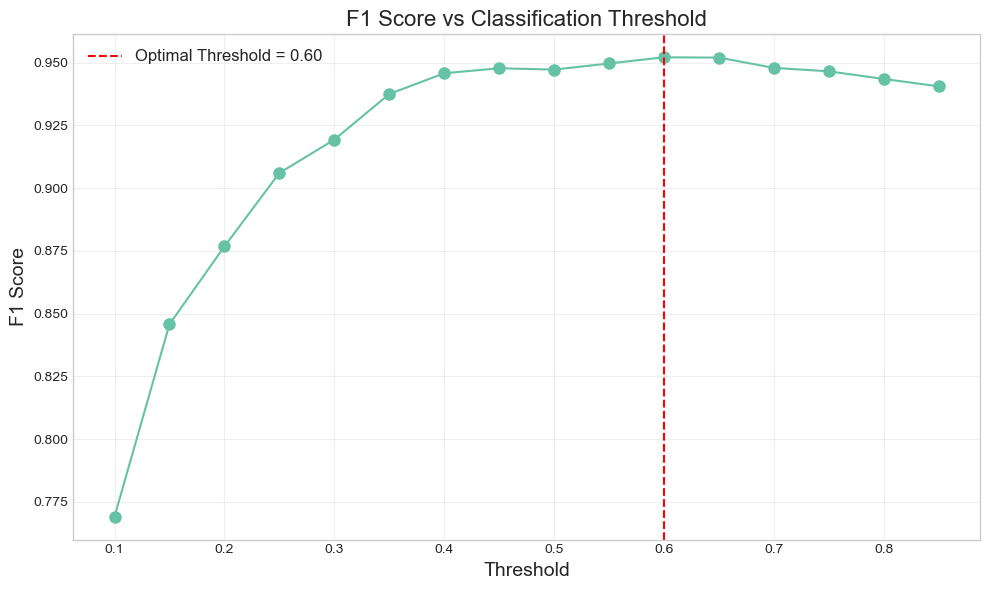

Optimal threshold: 0.60 with F1 score: 0.9521


In [19]:
def optimize_threshold(y_true, y_proba):
    """
    Find the optimal classification threshold based on F1 score.
    
    Parameters:
    -----------
    y_true : array
        True class labels
    y_proba : array
        Predicted probabilities for positive class
        
    Returns:
    --------
    optimal_threshold : float
        The threshold that maximizes the F1 score
    """
    # Initialize variables
    thresholds = np.arange(0.1, 0.9, 0.05)
    f1_scores = []
    
    # Calculate F1 score for each threshold
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        f1_scores.append(f1)
    
    # Find the threshold that maximizes the F1 score
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    optimal_f1 = f1_scores[optimal_idx]
    
    # Plot F1 score vs threshold
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores, '-o', markersize=8)
    plt.axvline(x=optimal_threshold, color='red', linestyle='--', 
                label=f'Optimal Threshold = {optimal_threshold:.2f}')
    plt.title('F1 Score vs Classification Threshold', fontsize=16)
    plt.xlabel('Threshold', fontsize=14)
    plt.ylabel('F1 Score', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig('plots/threshold_optimization.png')
    plt.show()
    
    print(f"Optimal threshold: {optimal_threshold:.2f} with F1 score: {optimal_f1:.4f}")
    
    return optimal_threshold

# Find optimal threshold
print("\nFinding optimal threshold...")
X_val = model_data['X_val_processed']  
val_proba = best_model.predict_proba(X_val)[:, 1]
optimal_threshold = optimize_threshold(model_data['y_val'], val_proba)


## 3.6 Learning Curve Analysis


Plotting learning curve...


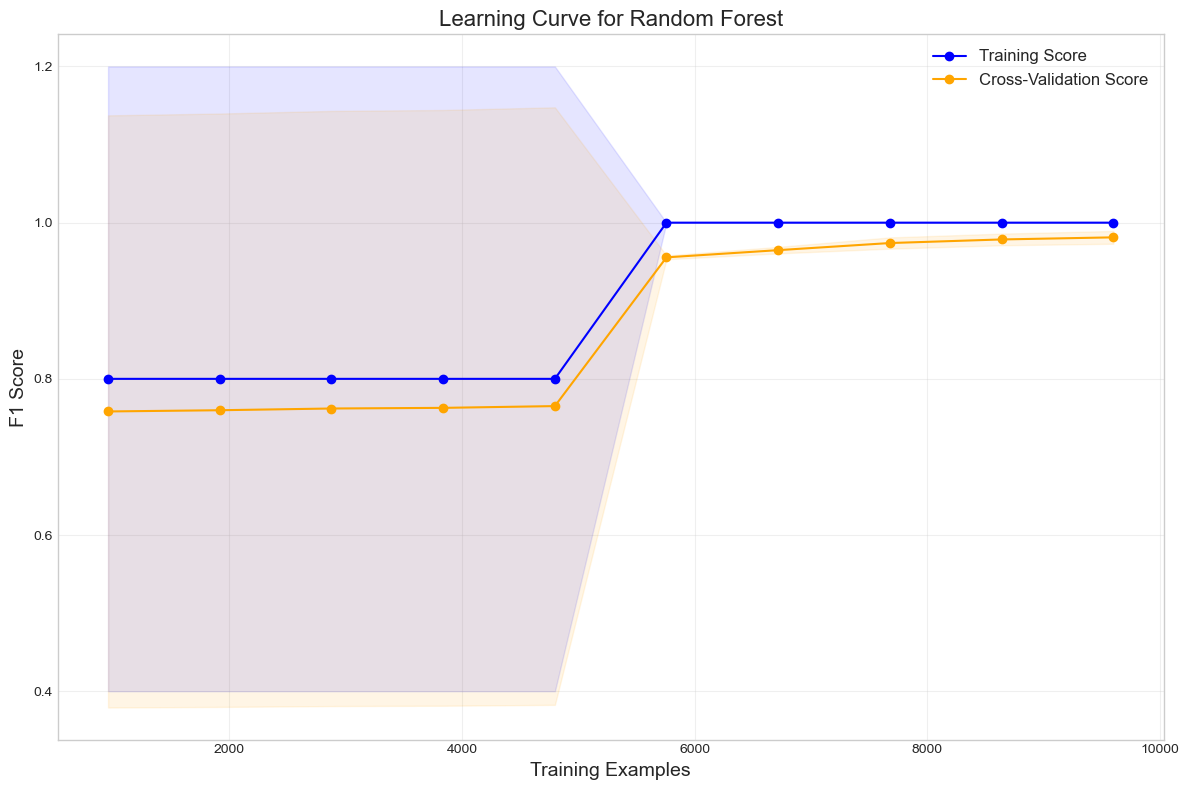

In [20]:
def plot_learning_curve(estimator, X, y, title="Learning Curve", cv=5, n_jobs=-1):
    """
    Plot the learning curve for a model to diagnose bias/variance issues.
    
    Parameters:
    -----------
    estimator : sklearn estimator
        The model to evaluate
    X : array
        Training data features
    y : array
        Training data target
    title : str, default="Learning Curve"
        Plot title
    cv : int, default=5
        Number of cross-validation folds
    n_jobs : int, default=-1
        Number of parallel jobs
    """
    
    # Calculate learning curve
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, 
        train_sizes=train_sizes, scoring='f1')
    
    # Calculate mean and standard deviation
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)
    
    # Plot learning curve
    plt.figure(figsize=(12, 8))
    plt.title(title, fontsize=16)
    plt.xlabel("Training Examples", fontsize=14)
    plt.ylabel("F1 Score", fontsize=14)
    plt.grid(True, alpha=0.3)
    
    # Plot training and validation scores
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="blue")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.1, color="orange")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="blue",
             label="Training Score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="orange",
             label="Cross-Validation Score")
    
    plt.legend(loc="best", fontsize=12)
    plt.tight_layout()
    plt.savefig(f'plots/learning_curve_{title.replace(" ", "_").lower()}.png')
    plt.show()

# Plot learning curve
print("\nPlotting learning curve...")
plot_learning_curve(best_model, model_data['X_train_processed'], model_data['y_train'], 
                   f"Learning Curve for {best_initial_model}")


## 3.7 Final Model Evaluation (Test Set)


Evaluating final model on test set...
Classification Report:
              precision    recall  f1-score   support

      Stayed       0.99      1.00      0.99      2001
        Left       0.98      0.93      0.95       398

    accuracy                           0.99      2399
   macro avg       0.98      0.96      0.97      2399
weighted avg       0.99      0.99      0.99      2399



<Figure size 800x600 with 0 Axes>

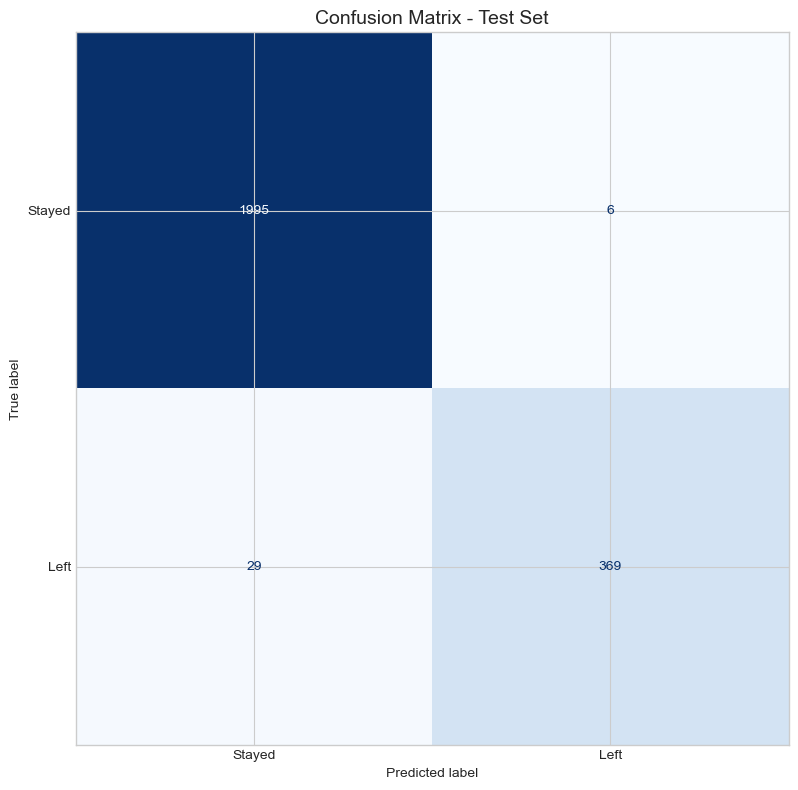

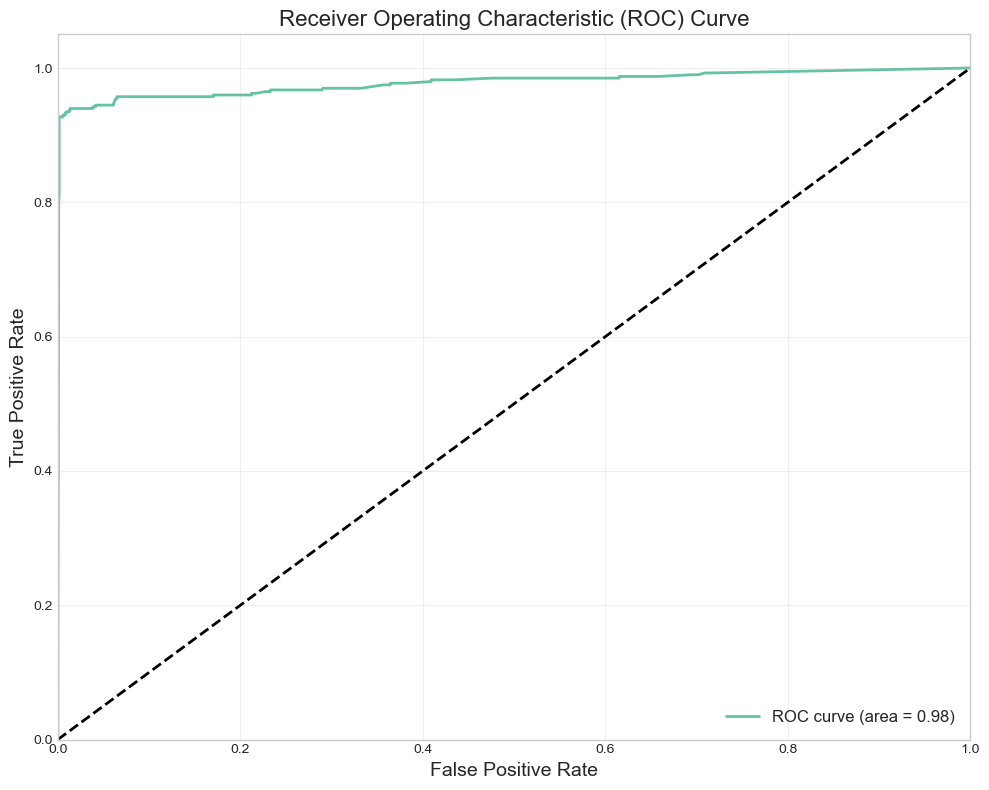

Accuracy: 0.9854
Precision: 0.9840
Recall: 0.9271
F1 Score: 0.9547
ROC AUC: 0.9782


In [ ]:

def final_model_evaluation(model, data, use_scaled=False, optimal_threshold=0.6):
    """
    Evaluate the final model on the test set.
    
    Parameters:
    -----------
    model : sklearn model
        The trained model
    data : dict
        Dictionary containing data splits and other metadata
    use_scaled : bool, default=False
        Whether to use scaled features
    optimal_threshold : float, default=0.5 
        Classification threshold to use "0.6"
        
    Returns:
    --------
    metrics : dict
        Dictionary of evaluation metrics
    y_test_pred : array
        Predictions on test data
    y_test_proba : array
        Predicted probabilities on test data
    """
    # Select the appropriate test dataset
    X_test = data['X_test_processed']
    y_test = data['y_test']
    
    # Make predictions
    y_test_proba = model.predict_proba(X_test)[:, 1]
    y_test_pred = (y_test_proba >= optimal_threshold).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_proba)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    
    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_test_pred, target_names=['Stayed', 'Left']))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Stayed', 'Left'])
    disp.plot(cmap='Blues', values_format='d', colorbar=False)
    plt.title('Confusion Matrix - Test Set', fontsize=14)
    plt.tight_layout()
    plt.savefig('plots/final_model_confusion_matrix.png')
    plt.show()
    
    
    # Plot ROC curve
    plt.figure(figsize=(10, 8))
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('plots/final_model_roc_curve.png')
    plt.show()
    
    # Compile metrics
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }
    
    return metrics, y_test_pred, y_test_proba

# Evaluate final model on test set
print("\nEvaluating final model on test set...")
test_metrics, y_test_pred, y_test_proba = final_model_evaluation(
    best_model, model_data, optimal_threshold=optimal_threshold
)

# Print summary metrics
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"F1 Score: {test_metrics['f1']:.4f}")
print(f"ROC AUC: {test_metrics['roc_auc']:.4f}")


## 3.8 Calibration Curve Analysis

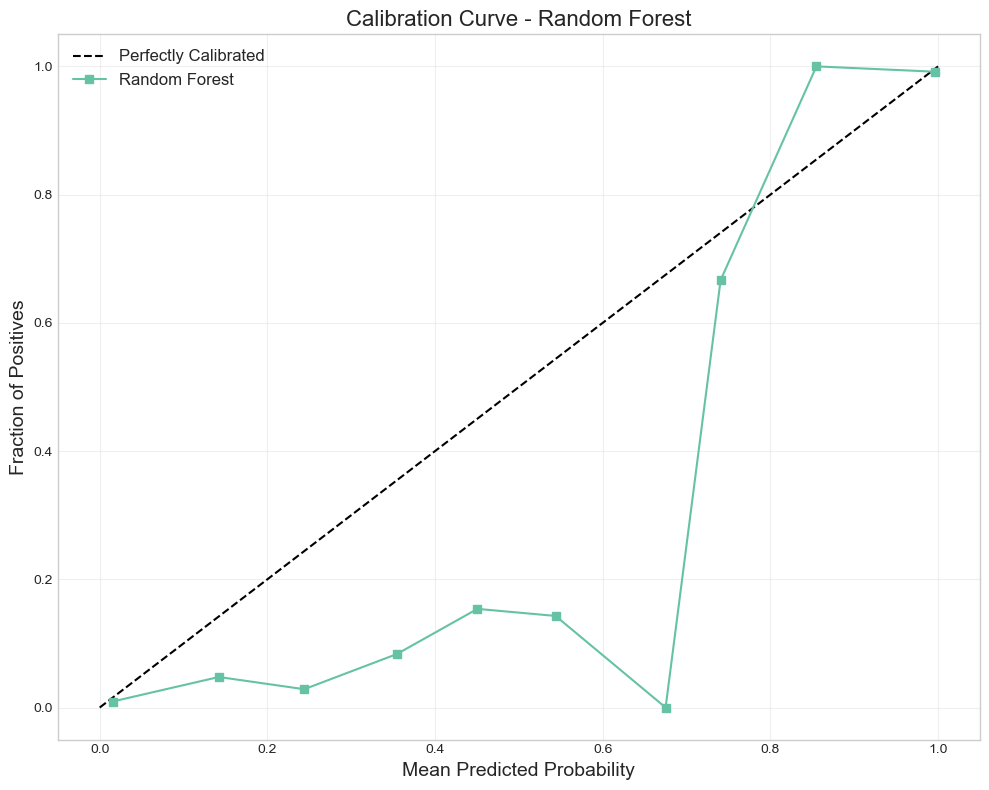

In [22]:
def plot_calibration_curve(y_true, y_prob, model_name):
    """
    Plot calibration curve for a model.
    
    Parameters:
    -----------
    y_true : array
        True binary labels
    y_prob : array
        Predicted probabilities
    model_name : str
        Name of the model
    """
    
    
    # Calculate calibration curve
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)
    
    # Plot calibration curve
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
    plt.plot(prob_pred, prob_true, 's-', label=model_name)
    
    plt.title(f'Calibration Curve - {model_name}', fontsize=16)
    plt.xlabel('Mean Predicted Probability', fontsize=14)
    plt.ylabel('Fraction of Positives', fontsize=14)
    plt.legend(loc='best', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'plots/calibration_curve_{model_name.replace(" ", "_").lower()}.png')
    plt.show()

# Plot calibration curve 
plot_calibration_curve(model_data['y_test'], y_test_proba, best_initial_model)



## 3.9 Feature Importance Analysis


Analyzing feature importance...


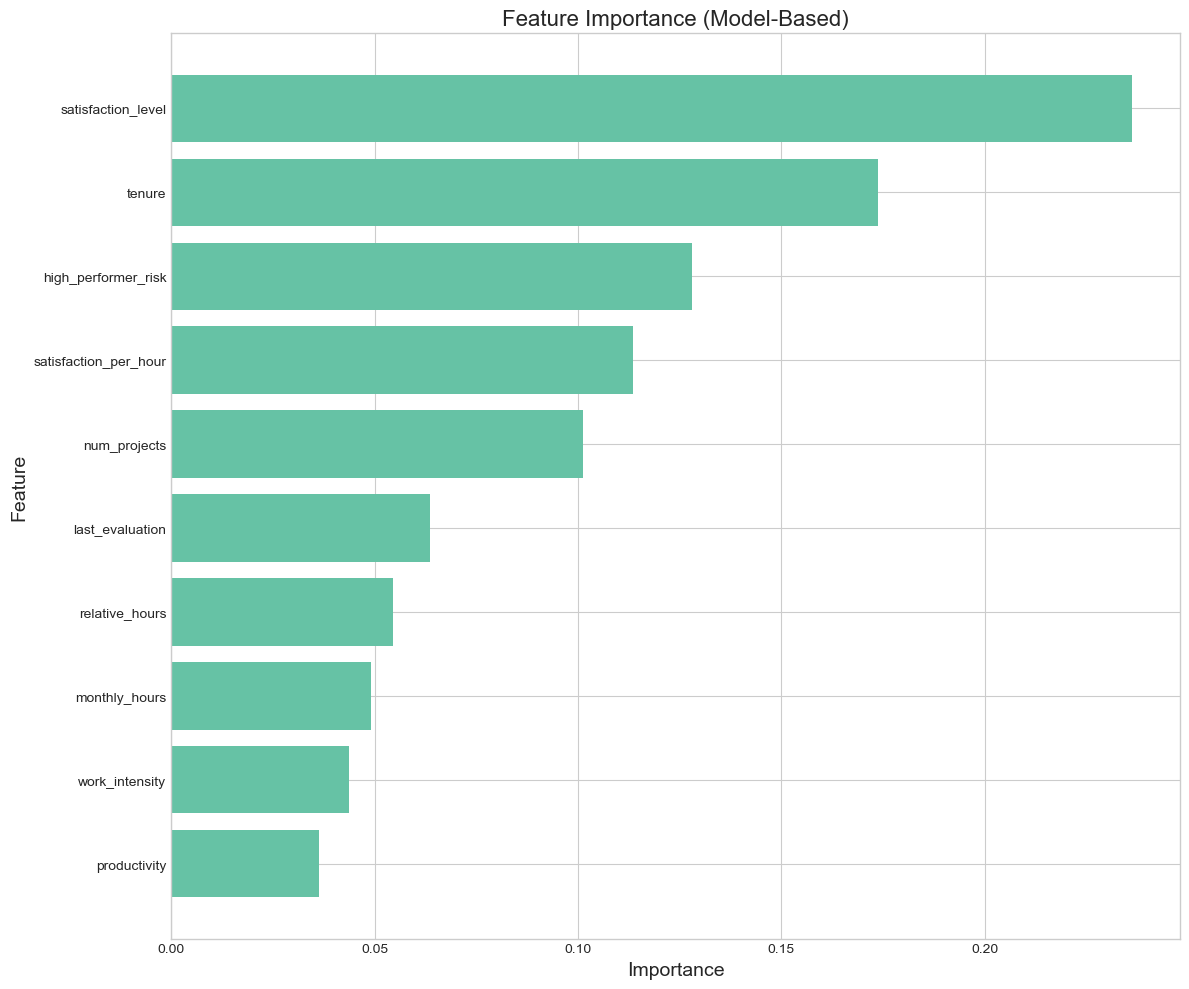

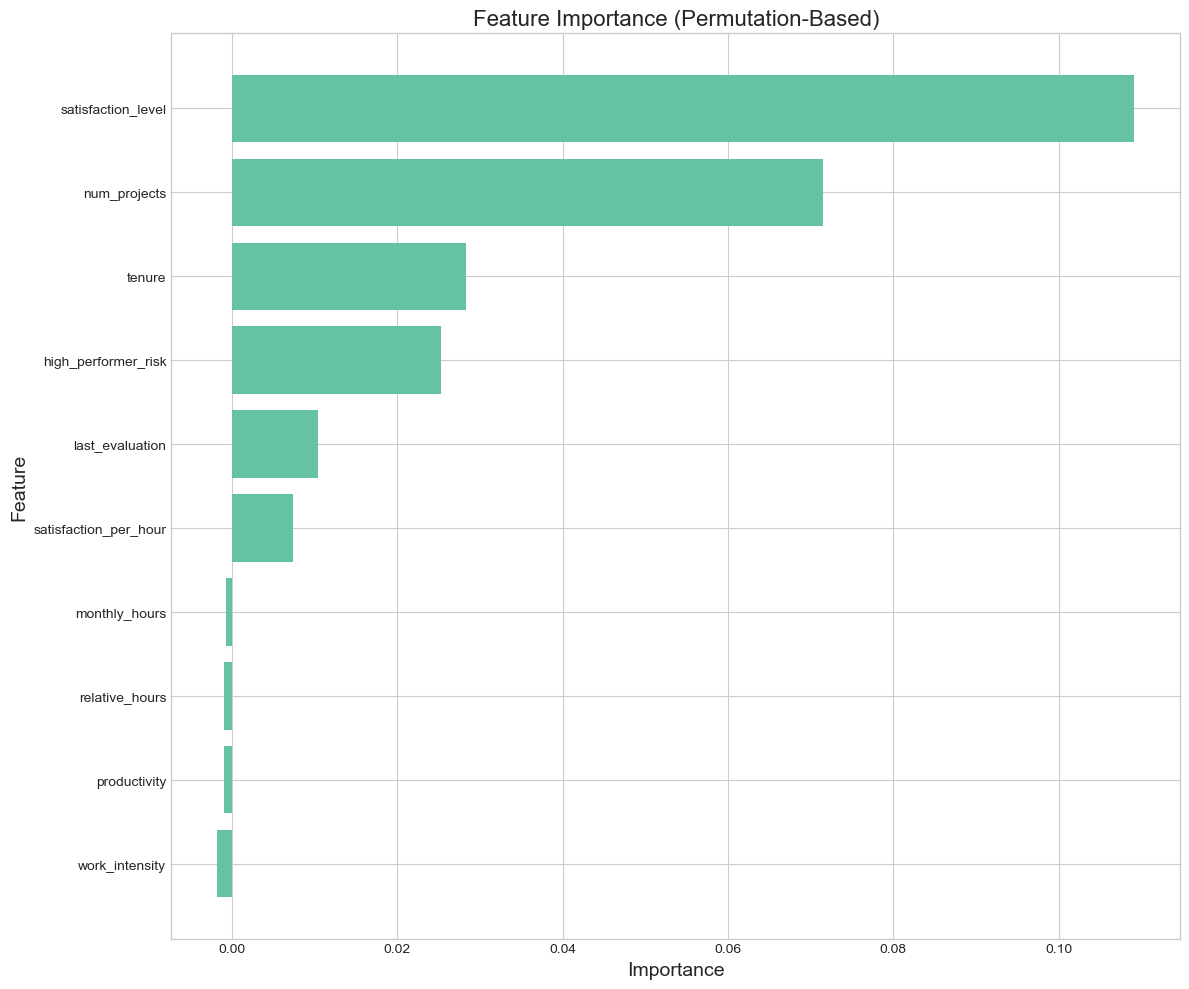


Top 10 factors influencing employee turnover (from model):
satisfaction_level: 0.2362
tenure: 0.1737
high_performer_risk: 0.1280
satisfaction_per_hour: 0.1134
num_projects: 0.1012
last_evaluation: 0.0637
relative_hours: 0.0546
monthly_hours: 0.0492
work_intensity: 0.0437
productivity: 0.0363

Top 10 factors from permutation importance (more robust):
satisfaction_level: 0.1091
num_projects: 0.0715
tenure: 0.0283
high_performer_risk: 0.0253
last_evaluation: 0.0105
satisfaction_per_hour: 0.0074
monthly_hours: -0.0008
relative_hours: -0.0009
productivity: -0.0009
work_intensity: -0.0018


In [23]:
def analyze_feature_importance(model, data, feature_names=None):
    """
    Analyze and visualize feature importance.
    """
   
    
    # Initialize feature importance DataFrame
    feature_importance_df = None
    
    # Get feature names if not provided
    if feature_names is None:
        if 'feature_names' in data:
            feature_names = data['feature_names']
        else:
            print("Warning: No feature names provided or found in data.")
            feature_names = [f"Feature {i}" for i in range(model.n_features_in_)]
    
    # Try to extract built-in feature importance (if available)
    if hasattr(model, 'feature_importances_'):
        # Get feature importance
        importances = model.feature_importances_
        
        # Check if lengths match
        if len(importances) != len(feature_names):
            print(f"Warning: Feature names length ({len(feature_names)}) doesn't match "
                  f"feature importances length ({len(importances)})")
            # Use generic feature names if they don't match
            feature_names_to_use = [f"Feature {i}" for i in range(len(importances))]
        else:
            feature_names_to_use = feature_names
        
        # Create DataFrame with feature names and importance
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names_to_use,
            'Importance': importances
        })
        
        # Sort by importance
        feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)
        
        # Plot feature importance
        plt.figure(figsize=(12, 10))
        plt.barh(feature_importance_df['Feature'][:15], feature_importance_df['Importance'][:15])
        plt.title('Feature Importance (Model-Based)', fontsize=16)
        plt.xlabel('Importance', fontsize=14)
        plt.ylabel('Feature', fontsize=14)
        plt.gca().invert_yaxis()  # Invert y-axis to have most important at the top
        plt.tight_layout()
        plt.savefig('plots/feature_importance.png')
        plt.show()
    
    # Calculate permutation importance (works for any model)
    # Select the appropriate dataset
    if 'X_test_processed' in data:
        X_test = data['X_test_processed']
    else:
        X_test = data['X_test']
    
    y_test = data['y_test']
    
    # Calculate permutation importance
    try:
        perm_importance = permutation_importance(model, X_test, y_test, 
                                               n_repeats=10, random_state=42)
        
        # Create DataFrame with feature names for permutation importance
        # Handle case where feature names don't match X_test dimensions
        if len(feature_names) != X_test.shape[1]:
            print(f"Warning: Feature names length ({len(feature_names)}) doesn't match "
                  f"X_test shape ({X_test.shape[1]})")
            perm_feature_names = [f"Feature {i}" for i in range(X_test.shape[1])]
        else:
            perm_feature_names = feature_names
        
        # Create DataFrame
        perm_importance_df = pd.DataFrame({
            'Feature': perm_feature_names,
            'Importance': perm_importance.importances_mean
        })
        
        # Sort by importance
        perm_importance_df = perm_importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)
        
        # Plot permutation importance
        plt.figure(figsize=(12, 10))
        plt.barh(perm_importance_df['Feature'][:15], perm_importance_df['Importance'][:15])
        plt.title('Feature Importance (Permutation-Based)', fontsize=16)
        plt.xlabel('Importance', fontsize=14)
        plt.ylabel('Feature', fontsize=14)
        plt.gca().invert_yaxis()  # Invert y-axis to have most important at the top
        plt.tight_layout()
        plt.savefig('plots/permutation_importance.png')
        plt.show()
        
    except Exception as e:
        print(f"Error calculating permutation importance: {str(e)}")
        perm_importance_df = pd.DataFrame(columns=['Feature', 'Importance'])
    
    return feature_importance_df, perm_importance_df

# Usage with the enhanced data preparation
print("\nAnalyzing feature importance...")
feature_importance, perm_importance = analyze_feature_importance(
    best_model, model_data
)

# Print top factors
if feature_importance is not None:
    print("\nTop 10 factors influencing employee turnover (from model):")
    for i, row in feature_importance.head(10).iterrows():
        print(f"{row['Feature']}: {row['Importance']:.4f}")

print("\nTop 10 factors from permutation importance (more robust):")
for i, row in perm_importance.head(10).iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")

# Part 4: Model Deployment and Business Recommendations

## 4.1 Create End-to-End Pipeline for Deployment

In [24]:
def create_end_to_end_pipeline(best_model, model_data, optimal_threshold):
    """Create and save a complete end-to-end pipeline that combines preprocessing and the model"""
    # Create directory for model artifacts
    os.makedirs('model', exist_ok=True)
    
    # Create a single pipeline that combines preprocessing and model
    complete_pipeline = Pipeline([
        ('preprocessor', model_data['pipeline']),  # Preprocessing and feature selection
        ('model', best_model)                     # The trained model
    ])
    
    # Save the complete pipeline
    joblib.dump(complete_pipeline, 'model/complete_pipeline.pkl')
    
    # Save the threshold separately
    with open('model/optimal_threshold.txt', 'w') as f:
        f.write(str(optimal_threshold))
    
    # For reference, save feature names and other metadata
    with open('model/model_info.txt', 'w') as f:
        f.write(f"Model type: {type(best_model).__name__}\n")
        f.write(f"Optimal threshold: {optimal_threshold}\n")
        f.write(f"Features used: {', '.join(model_data['feature_names'])}\n")
    
    print("End-to-end pipeline saved successfully")
    return complete_pipeline

# Save the complete pipeline
create_end_to_end_pipeline(best_model, model_data, optimal_threshold)


End-to-end pipeline saved successfully


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num',
                                                                   StandardScaler(),
                                                                   ['satisfaction_level',
                                                                    'last_evaluation',
                                                                    'num_projects',
                                                                    'monthly_hours',
                                                                    'tenure',
                                                                    'work_intensity',
                                                                    'poor_work_life_balance',
                                                                    'burnout_risk',
                                                                    'high_performer_risk',
                                                                    'satisfaction_per_hour',
                                                                    'relative_hours']),
                                                                  ('cat',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False),
                                                                   ['department',
                                                                    'salary_level'])])),
                                 ('feature_selection',
                                  SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                                                  max_features=10))])),
                ('model',
                 RandomForestClassifier(max_depth=20, n_estimators=200,
                                        random_state=42))])

## 4.2 Feature Engineering Function for New Employees

In [25]:
def engineer_features_for_prediction(employee_data):
    """Apply feature engineering to new employee data"""
    # Convert dict to numeric values where needed
    for key, value in employee_data.items():
        if key in ['satisfaction_level', 'last_evaluation']:
            employee_data[key] = float(value)
        elif key in ['num_projects', 'monthly_hours', 'tenure', 'had_accident', 'promotion_last_5yr']:
            employee_data[key] = int(value)
    
    # Calculate work intensity
    employee_data['work_intensity'] = employee_data['monthly_hours'] / employee_data['num_projects']
    
    # Calculate relative hours (assuming 175 is average from our dataset)
    avg_hours = 175
    employee_data['relative_hours'] = employee_data['monthly_hours'] / avg_hours
    
    # Calculate overworked
    employee_data['overworked'] = int((employee_data['monthly_hours'] > avg_hours) and 
                                    (employee_data['num_projects'] > 4))
    
    # Calculate poor work-life balance
    employee_data['poor_work_life_balance'] = int(employee_data['monthly_hours'] > 200)

    # Calculate productivity
    employee_data['productivity'] = employee_data['last_evaluation'] / employee_data['num_projects']
    
    # Calculate satisfaction per hour
    employee_data['satisfaction_per_hour'] = employee_data['satisfaction_level'] / (employee_data['monthly_hours'] / 160)
    
    # Calculate underutilized
    employee_data['underutilized'] = int((employee_data['last_evaluation'] > 0.75) and 
                                         (employee_data['num_projects'] < 3))
    
    # Calculate burnout risk
    employee_data['burnout_risk'] = int((employee_data['monthly_hours'] > 250) and 
                                        (employee_data['num_projects'] > 5) and 
                                        (employee_data['satisfaction_level'] < 0.5))
    
    # Calculate flight risk
    employee_data['flight_risk'] = int((employee_data['satisfaction_level'] < 0.4) and 
                                       (employee_data['tenure'] > 3) and 
                                       (employee_data['last_evaluation'] > 0.7))
    
    # Calculate high performer risk
    employee_data['high_performer_risk'] = int((employee_data['last_evaluation'] > 0.8) and 
                                              (employee_data['promotion_last_5yr'] == 0) and 
                                              (employee_data['tenure'] > 4))
    
    return employee_data

## 4.3 Risk Identification Function

In [26]:
def identify_risk_factors(employee_data, probability):
    """Identify key risk factors for an employee"""
    risk_factors = []
    
    # Only identify risk factors if probability is concerning
    if probability < 0.2:
        return ["No significant risk factors identified."]
    
    # Check various factors based on data analysis
    if employee_data['satisfaction_level'] < 0.4:
        risk_factors.append("Low satisfaction level")
    
    if employee_data['last_evaluation'] > 0.8 and employee_data['promotion_last_5yr'] == 0:
        risk_factors.append("High performer without recent promotion")
    
    if employee_data['num_projects'] > 5:
        risk_factors.append("High workload (too many projects)")
    
    if employee_data['monthly_hours'] > 220:
        risk_factors.append("Excessive working hours")
    
    if employee_data['tenure'] > 5 and employee_data['promotion_last_5yr'] == 0:
        risk_factors.append("Long tenure without promotion")
    
    if employee_data['salary_level'] == 'low' and employee_data['last_evaluation'] > 0.7:
        risk_factors.append("Good performer with low compensation")
    
    if employee_data['burnout_risk'] == 1:
        risk_factors.append("Signs of burnout")
    
    if employee_data['work_intensity'] > 50:  # Hours per project is high
        risk_factors.append("Work is too intense")
        
    if employee_data['poor_work_life_balance'] == 1:
        risk_factors.append("Poor work-life balance")
        
    if employee_data['flight_risk'] == 1:
        risk_factors.append("Classic flight risk profile (low satisfaction but high evaluation)")
    
    # If no specific risk factors were identified but probability is high
    if len(risk_factors) == 0 and probability > 0.5:
        risk_factors.append("Multiple moderate factors contributing to turnover risk")
    
    return risk_factors

## 4.4 Recommendation Function

In [27]:
def recommend_actions(risk_factors):
    """Recommend actions based on identified risk factors"""
    actions = []
    
    if "Low satisfaction level" in risk_factors:
        actions.append("Schedule a check-in meeting to discuss job satisfaction and address concerns")
    
    if "High performer without recent promotion" in risk_factors:
        actions.append("Review promotion timeline and consider career development opportunities")
    
    if "High workload (too many projects)" in risk_factors:
        actions.append("Evaluate workload distribution and consider redistributing projects")
    
    if "Excessive working hours" in risk_factors:
        actions.append("Monitor work hours and encourage better work-life balance")
    
    if "Long tenure without promotion" in risk_factors:
        actions.append("Discuss career path and potential for advancement or skill development")
    
    if "Good performer with low compensation" in risk_factors:
        actions.append("Review compensation package in line with performance")
    
    if "Signs of burnout" in risk_factors or "Work is too intense" in risk_factors:
        actions.append("Provide resources for stress management and consider temporary workload reduction")
    
    if "Poor work-life balance" in risk_factors:
        actions.append("Encourage use of vacation time and establish clearer work boundaries")
    
    if "Classic flight risk profile" in risk_factors:
        actions.append("Urgent intervention needed - schedule meeting with HR and manager to develop retention plan")
    
    # If no specific actions were recommended
    if len(actions) == 0:
        actions.append("General monitoring recommended - no specific intervention needed at this time")
    
    return actions

## 4.5 Main Prediction Function


In [28]:
def predict_employee_turnover(employee_data):
    """Make a prediction for a single employee with the full pipeline"""

    
    # Load the complete pipeline and threshold
    try:
        complete_pipeline = joblib.load('model/complete_pipeline.pkl')
        
        with open('model/optimal_threshold.txt', 'r') as f:
            optimal_threshold = float(f.read().strip())
            
        print("Models and artifacts loaded successfully")
    except FileNotFoundError as e:
        print(f"Error loading model artifacts: {str(e)}")
        return None
    
    # Engineer features for prediction
    engineered_data = engineer_features_for_prediction(employee_data)
    
    # Convert to DataFrame
    employee_df = pd.DataFrame([engineered_data])
    
    # Get probability from the complete pipeline
    try:
        probability = complete_pipeline.predict_proba(employee_df)[0, 1]
        prediction = 1 if probability >= optimal_threshold else 0
    except Exception as e:
        print(f"Error during prediction: {str(e)}")
        return None
    
    # Define risk level
    if probability < 0.3:
        risk_level = "Low"
    elif probability < 0.7:
        risk_level = "Medium"
    else:
        risk_level = "High"
    
    # Identify risk factors and recommend actions
    risk_factors = identify_risk_factors(engineered_data, probability)
    recommended_actions = recommend_actions(risk_factors)
    
    # Create result dictionary
    result = {
        "employee_id": employee_data.get("employee_id", "Not provided"),
        "turnover_prediction": "Yes" if prediction == 1 else "No",
        "turnover_probability": float(probability),
        "risk_level": risk_level,
        "risk_factors": risk_factors,
        "recommended_actions": recommended_actions
    }
    
    # Print the results in a readable format
    print("\nEmployee Turnover Risk Assessment")
    print("==================================")
    print(f"Employee ID: {result['employee_id']}")
    print(f"Turnover Prediction: {result['turnover_prediction']}")
    print(f"Probability of Leaving: {result['turnover_probability']:.1%}")
    print(f"Risk Level: {result['risk_level']}")
    
    print("\nKey Risk Factors:")
    for factor in result['risk_factors']:
        print(f"- {factor}")
    
    print("\nRecommended Actions:")
    for action in result['recommended_actions']:
        print(f"- {action}")
    
    return result


# Example usage
if __name__ == "__main__":
    # Example employee for prediction
    example_employee = {
        "employee_id": "EMP12345",
        "satisfaction_level": 0.3,
        "last_evaluation": 0.8,
        "num_projects": 7,
        "monthly_hours": 280,
        "tenure": 4,
        "had_accident": 0,
        "promotion_last_5yr": 0,
        "department": "sales", 
        "salary_level": "medium"
    }
    
    # Make prediction
    result = predict_employee_turnover(example_employee)

Models and artifacts loaded successfully

Employee Turnover Risk Assessment
Employee ID: EMP12345
Turnover Prediction: Yes
Probability of Leaving: 73.0%
Risk Level: High

Key Risk Factors:
- Low satisfaction level
- High workload (too many projects)
- Excessive working hours
- Signs of burnout
- Poor work-life balance
- Classic flight risk profile (low satisfaction but high evaluation)

Recommended Actions:
- Schedule a check-in meeting to discuss job satisfaction and address concerns
- Evaluate workload distribution and consider redistributing projects
- Monitor work hours and encourage better work-life balance
- Provide resources for stress management and consider temporary workload reduction
- Encourage use of vacation time and establish clearer work boundaries
